In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import datetime as dt

## Paths to Files

In [2]:
BASE_DIR_PATH = '/Users/neilb/Documents/dsci_thesis/'
DATA_PATH = 'Scraping_and_Cleaning'

In [3]:
DATASET_FILE = os.path.join(BASE_DIR_PATH, DATA_PATH, 'data_2022.csv')

## Load Dataset

In [4]:
df = pd.read_csv(DATASET_FILE)
df['datetime'] = pd.to_datetime(df['datetime']) # parsing column to datetime as it is read as string
df.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr
0,2022-01-01,11.64,Airport (PAGASA),0.0,0.0,0.0,0.0,0.0
1,2022-01-01,11.64,Antipolo,0.0,0.0,0.0,0.0,0.0
2,2022-01-01,11.64,Bagong Nayon,0.0,0.0,0.0,0.0,0.0
3,2022-01-01,11.64,Boso Boso,0.0,0.0,0.0,0.0,0.0
4,2022-01-01,11.64,Calawis,0.0,0.0,0.0,0.0,0.0


## Basic dataset information

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227786 entries, 0 to 227785
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   datetime     227786 non-null  datetime64[ns]
 1   water_level  227786 non-null  float64       
 2   station      227786 non-null  object        
 3   1hr          227786 non-null  float64       
 4   3hr          227786 non-null  float64       
 5   6hr          227786 non-null  float64       
 6   12hr         227786 non-null  float64       
 7   24hr         227786 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 13.9+ MB


In [6]:
df.describe()

,water_level,1hr,3hr,6hr,12hr,24hr
count,227786.000000,227786.000000,227786.000000,227786.000000,227786.000000,227786.000000
mean,11.822638,0.212392,0.637735,1.275366,2.550725,5.101611
std,0.714605,1.760464,3.715819,5.821120,9.058985,14.045297
min,10.980000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.280000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,11.590000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.240000,0.000000,0.000000,0.000000,0.000000,2.500000
max,18.500000,97.000000,161.500000,163.000000,163.000000,209.000000


## Picking Stations Based on Correlation

In [7]:
def make_corr_heatmap(dataframe):
    '''
    Making a correlation heatmap for dataframe
    '''
    corr_matrix = dataframe.corr()
    corr_heatmap = sns.heatmap(corr_matrix, annot=True)
    plt.show()

In [8]:
def make_rainfall_hydrograph(dataframe, title, interval, max_rain=None, max_waterlevel=None):
    '''
    Making a hydrograph using dataframe with a title
    dataframe must contain water level and rainfall data
    Also plots the point of max rain and max water level
    '''    
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.tick_params(axis='x', labelsize=6)
    
    l1, = ax.plot(dataframe['datetime'], dataframe['water_level'], color='red', alpha=0.7)
    if max_waterlevel is not None:
        ax.plot(max_waterlevel['datetime'], max_waterlevel['water_level'], 'ro')
        ax.axvline(max_waterlevel['datetime'], color='red', linestyle=':')
    
    ax2.invert_yaxis()
    l2, = ax2.plot(dataframe['datetime'], dataframe[interval], color='blue', alpha=0.5)
    if max_rain is not None:
        ax2.plot(max_rain['datetime'], max_rain[interval], 'bo')
        ax.axvline(max_rain['datetime'], color='blue', linestyle=':')
    
    ax2.legend([l1, l2], ['Water Level in m', 'Rainfall in mm'], loc='center left')
    ax2.set_title(title)

In [9]:
def get_storm_event(dataframe, date, days=0):
    '''
    Get storm event from dataframe centered around date, 
    with start date at days, hours before date and
    end date at days, hours after date
    '''
    start_date = dt.datetime.strptime(date, '%Y-%m-%d') - dt.timedelta(days=days)
    end_date = dt.datetime.strptime(date, '%Y-%m-%d') + dt.timedelta(days=days)

    after_start_date = dataframe['datetime'] >= start_date
    before_end_date = dataframe['datetime'] <= end_date

    storm_event = dataframe[after_start_date & before_end_date]
    
    return storm_event

In [10]:
def get_maxes(dataframe):
    '''
    Get max rainfall and max water level of dataframe
    Print the output
    '''
    maxes = []
    
    for index in dataframe[['water_level', '1hr', '24hr']].idxmax():
        maxes.append(dataframe.loc[index])
        
    return maxes[0], maxes[1], maxes[2]

In [11]:
df['time'] = df['datetime'].dt.time
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227786 entries, 0 to 227785
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   datetime     227786 non-null  datetime64[ns]
 1   water_level  227786 non-null  float64       
 2   station      227786 non-null  object        
 3   1hr          227786 non-null  float64       
 4   3hr          227786 non-null  float64       
 5   6hr          227786 non-null  float64       
 6   12hr         227786 non-null  float64       
 7   24hr         227786 non-null  float64       
 8   time         227786 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 15.6+ MB


In [12]:
daily_df = df[df['time'] == dt.time(0,0,0)]
daily_df = daily_df[['datetime', 'water_level', 'station', '24hr']]
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9516 entries, 0 to 227785
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     9516 non-null   datetime64[ns]
 1   water_level  9516 non-null   float64       
 2   station      9516 non-null   object        
 3   24hr         9516 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 371.7+ KB


In [13]:
daily_df.head()

,datetime,water_level,station,24hr
0,2022-01-01,11.64,Airport (PAGASA),0.0
1,2022-01-01,11.64,Antipolo,0.0
2,2022-01-01,11.64,Bagong Nayon,0.0
3,2022-01-01,11.64,Boso Boso,0.0
4,2022-01-01,11.64,Calawis,0.0


### Normal Column-pairwise Pearson Correlation

In [14]:
stations = df['station'].unique()

for station in stations:
    df_subset = df[df['station'] == station]
    print(f'{station}\n{df_subset.corr()}\n\n')
    
# Sitio Wawa has highest correlation between water level and 24hr rain

Airport (PAGASA)
             water_level       1hr       3hr       6hr      12hr      24hr
water_level     1.000000  0.193085  0.298157  0.386576  0.468893  0.513276
1hr             0.193085  1.000000  0.572381  0.397310  0.328206  0.249952
3hr             0.298157  0.572381  1.000000  0.782216  0.597803  0.442086
6hr             0.386576  0.397310  0.782216  1.000000  0.798942  0.599157
12hr            0.468893  0.328206  0.597803  0.798942  1.000000  0.796749
24hr            0.513276  0.249952  0.442086  0.599157  0.796749  1.000000


Antipolo
             water_level       1hr       3hr       6hr      12hr      24hr
water_level     1.000000  0.155827  0.252650  0.347012  0.433350  0.485332
1hr             0.155827  1.000000  0.680736  0.499851  0.374608  0.278407
3hr             0.252650  0.680736  1.000000  0.784711  0.586232  0.435466
6hr             0.347012  0.499851  0.784711  1.000000  0.780530  0.585460
12hr            0.433350  0.374608  0.586232  0.780530  1.000000  0.7852

Sitio Wawa
             water_level       1hr       3hr       6hr      12hr      24hr
water_level     1.000000  0.179482  0.286037  0.398228  0.517181  0.587372
1hr             0.179482  1.000000  0.711460  0.535107  0.391127  0.297218
3hr             0.286037  0.711460  1.000000  0.810809  0.598664  0.446560
6hr             0.398228  0.535107  0.810809  1.000000  0.793658  0.586454
12hr            0.517181  0.391127  0.598664  0.793658  1.000000  0.777973
24hr            0.587372  0.297218  0.446560  0.586454  0.777973  1.000000


Taytay
             water_level       1hr       3hr       6hr      12hr      24hr
water_level     1.000000  0.175277  0.277800  0.377030  0.472990  0.529944
1hr             0.175277  1.000000  0.669355  0.492410  0.367369  0.274081
3hr             0.277800  0.669355  1.000000  0.781377  0.580015  0.429016
6hr             0.377030  0.492410  0.781377  1.000000  0.777758  0.579696
12hr            0.472990  0.367369  0.580015  0.777758  1.000000  0.780554
24hr 


Sitio Wawa


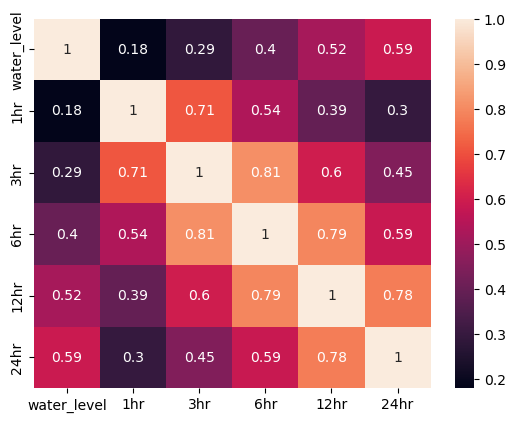

In [15]:
df_subset = df[df['station'] == 'Sitio Wawa']
print(f'\nSitio Wawa')
make_corr_heatmap(df_subset)

### Viewing Station with highest correlation between water level and 24hr rainfall

In [16]:
daily_sw_df = daily_df[daily_df['station'] == 'Sitio Wawa']
daily_sw_df

,datetime,water_level,station,24hr
23,2022-01-01,11.64,Sitio Wawa,0.0
647,2022-01-02,11.64,Sitio Wawa,0.0
1271,2022-01-03,11.64,Sitio Wawa,0.0
1895,2022-01-04,11.67,Sitio Wawa,0.0
2519,2022-01-05,11.68,Sitio Wawa,0.0
...,...,...,...,...
225287,2022-12-28,12.19,Sitio Wawa,0.0
225911,2022-12-29,12.17,Sitio Wawa,0.0
226535,2022-12-30,12.11,Sitio Wawa,2.5
227159,2022-12-31,12.12,Sitio Wawa,0.5


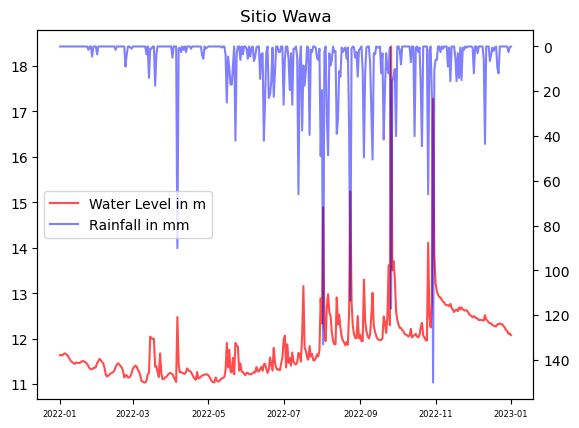

In [17]:
make_rainfall_hydrograph(daily_sw_df, 'Sitio Wawa', '24hr')

In [18]:
daily_sw_df.sort_values(by='24hr', ascending=False).head()

,datetime,water_level,station,24hr
188471,2022-10-30,17.28,Sitio Wawa,150.0
132935,2022-08-02,14.89,Sitio Wawa,133.0
167255,2022-09-26,18.43,Sitio Wawa,117.0
146663,2022-08-24,15.24,Sitio Wawa,113.5
59303,2022-04-06,12.48,Sitio Wawa,90.0


In [19]:
sitio_wawa_df = df[df['station']=='Sitio Wawa']
sitio_wawa_df

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
23,2022-01-01 00:00:00,11.64,Sitio Wawa,0.0,0.0,0.0,0.0,0.0,00:00:00
49,2022-01-01 01:00:00,11.61,Sitio Wawa,0.0,0.0,0.0,0.0,0.0,01:00:00
75,2022-01-01 02:00:00,11.58,Sitio Wawa,0.0,0.0,0.0,0.0,0.0,02:00:00
101,2022-01-01 03:00:00,11.55,Sitio Wawa,0.0,0.0,0.0,0.0,0.0,03:00:00
127,2022-01-01 04:00:00,11.49,Sitio Wawa,0.0,0.0,0.0,0.0,0.0,04:00:00
...,...,...,...,...,...,...,...,...,...
227679,2022-12-31 20:00:00,12.11,Sitio Wawa,0.0,0.0,0.0,0.0,0.0,20:00:00
227705,2022-12-31 21:00:00,12.11,Sitio Wawa,0.0,0.0,0.0,0.0,0.0,21:00:00
227731,2022-12-31 22:00:00,12.09,Sitio Wawa,0.0,0.0,0.0,0.0,0.0,22:00:00
227757,2022-12-31 23:00:00,12.09,Sitio Wawa,0.0,0.0,0.0,0.0,0.0,23:00:00


In [20]:
sitio_wawa_storm_event1 = get_storm_event(sitio_wawa_df, '2022-04-06', days=2)
sitio_wawa_storm_event1.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
58055,2022-04-04 00:00:00,11.11,Sitio Wawa,0.0,0.0,0.0,0.0,0.0,00:00:00
58081,2022-04-04 01:00:00,11.12,Sitio Wawa,0.0,0.0,0.0,0.0,0.0,01:00:00
58107,2022-04-04 02:00:00,11.12,Sitio Wawa,0.0,0.0,0.0,0.0,0.0,02:00:00
58133,2022-04-04 03:00:00,11.12,Sitio Wawa,0.0,0.0,0.0,0.0,0.0,03:00:00
58159,2022-04-04 04:00:00,11.09,Sitio Wawa,0.0,0.0,0.0,0.0,0.0,04:00:00


In [21]:
sitio_wawa_storm_event1.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
60447,2022-04-07 20:00:00,11.32,Sitio Wawa,0.0,0.0,0.0,0.0,0.5,20:00:00
60473,2022-04-07 21:00:00,11.28,Sitio Wawa,0.0,0.0,0.0,0.0,0.5,21:00:00
60499,2022-04-07 22:00:00,11.28,Sitio Wawa,0.0,0.0,0.0,0.0,0.5,22:00:00
60525,2022-04-07 23:00:00,11.27,Sitio Wawa,0.0,0.0,0.0,0.0,0.5,23:00:00
60551,2022-04-08 00:00:00,11.26,Sitio Wawa,0.0,0.0,0.0,0.0,0.5,00:00:00


In [22]:
sw_max_water_1, sw_max_1rain_1, sw_max_24rain_1 = get_maxes(sitio_wawa_storm_event1)

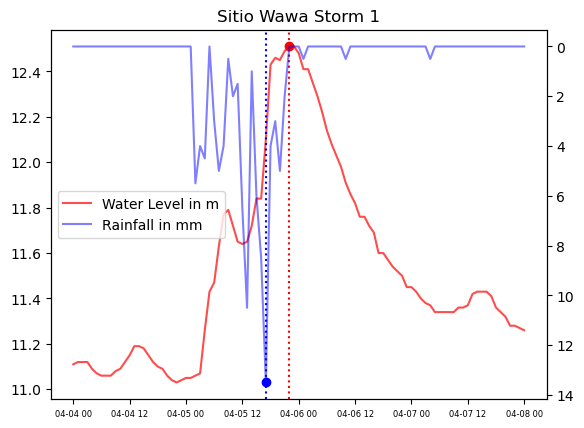

In [23]:
make_rainfall_hydrograph(sitio_wawa_storm_event1, 'Sitio Wawa Storm 1', '1hr', sw_max_1rain_1, sw_max_water_1)

In [24]:
sitio_wawa_storm_event2 = get_storm_event(sitio_wawa_df, '2022-08-02', days=4.5)
sitio_wawa_storm_event2.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
130127,2022-07-28 12:00:00,11.65,Sitio Wawa,0.0,0.0,0.0,0.0,5.0,12:00:00
130153,2022-07-28 13:00:00,11.65,Sitio Wawa,0.0,0.0,0.0,0.0,5.0,13:00:00
130179,2022-07-28 14:00:00,11.60,Sitio Wawa,0.0,0.0,0.0,0.0,5.0,14:00:00
130205,2022-07-28 15:00:00,11.59,Sitio Wawa,0.0,0.0,0.0,0.0,5.0,15:00:00
130231,2022-07-28 16:00:00,11.59,Sitio Wawa,0.0,0.0,0.0,0.0,5.0,16:00:00


In [25]:
sitio_wawa_storm_event2.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
135639,2022-08-06 08:00:00,13.29,Sitio Wawa,0.0,0.0,0.5,16.0,34.5,08:00:00
135665,2022-08-06 09:00:00,13.20,Sitio Wawa,0.0,0.0,0.0,16.0,34.5,09:00:00
135691,2022-08-06 10:00:00,13.20,Sitio Wawa,0.0,0.0,0.0,12.0,34.5,10:00:00
135717,2022-08-06 11:00:00,13.13,Sitio Wawa,0.0,0.0,0.0,1.0,34.5,11:00:00
135743,2022-08-06 12:00:00,13.08,Sitio Wawa,0.0,0.0,0.0,0.5,32.5,12:00:00


In [26]:
sw_max_water_2, sw_max_1rain_2, sw_max_24rain_2 = get_maxes(sitio_wawa_storm_event2)

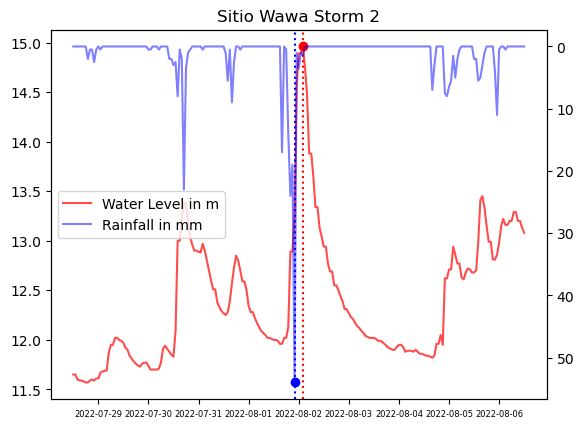

In [27]:
make_rainfall_hydrograph(sitio_wawa_storm_event2, 'Sitio Wawa Storm 2', '1hr', sw_max_1rain_2, sw_max_water_2)

In [28]:
sitio_wawa_storm_event3 = get_storm_event(sitio_wawa_df, '2022-08-24', days=5)
sitio_wawa_storm_event3.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
143543,2022-08-19 00:00:00,11.92,Sitio Wawa,0.0,0.0,0.0,1.0,1.0,00:00:00
143569,2022-08-19 01:00:00,11.92,Sitio Wawa,0.0,0.0,0.0,0.0,1.0,01:00:00
143595,2022-08-19 02:00:00,11.91,Sitio Wawa,0.0,0.0,0.0,0.0,1.0,02:00:00
143621,2022-08-19 03:00:00,11.90,Sitio Wawa,0.0,0.0,0.0,0.0,1.0,03:00:00
143647,2022-08-19 04:00:00,11.90,Sitio Wawa,0.0,0.0,0.0,0.0,1.0,04:00:00


In [29]:
sitio_wawa_storm_event3.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
149679,2022-08-28 20:00:00,12.09,Sitio Wawa,0.0,0.0,2.5,2.5,2.5,20:00:00
149705,2022-08-28 21:00:00,12.11,Sitio Wawa,0.0,0.0,2.5,2.5,2.5,21:00:00
149731,2022-08-28 22:00:00,12.03,Sitio Wawa,0.0,0.0,0.0,2.5,2.5,22:00:00
149757,2022-08-28 23:00:00,12.02,Sitio Wawa,0.0,0.0,0.0,2.5,2.5,23:00:00
149783,2022-08-29 00:00:00,12.01,Sitio Wawa,0.0,0.0,0.0,2.5,2.5,00:00:00


In [30]:
sw_max_water_3, sw_max_1rain_3, sw_max_24rain_3 = get_maxes(sitio_wawa_storm_event3)

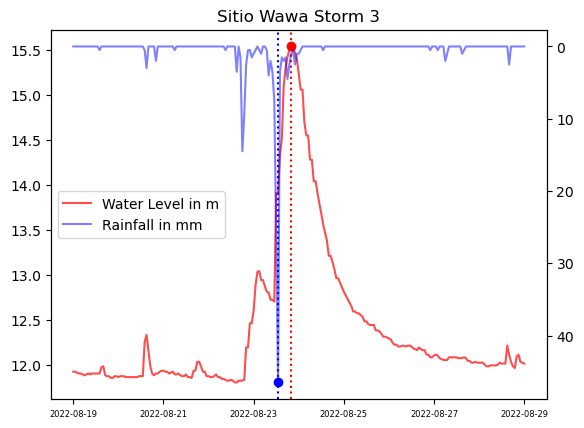

In [70]:
make_rainfall_hydrograph(sitio_wawa_storm_event3, 'Sitio Wawa Storm 3', '1hr', sw_max_1rain_3, sw_max_water_3)

In [32]:
sitio_wawa_storm_event4 = get_storm_event(sitio_wawa_df, '2022-09-26', days=7)
sitio_wawa_storm_event4.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
162887,2022-09-19 00:00:00,12.01,Sitio Wawa,1.0,2.5,3.0,3.0,3.0,00:00:00
162913,2022-09-19 01:00:00,11.96,Sitio Wawa,1.5,2.5,4.5,4.5,4.5,01:00:00
162939,2022-09-19 02:00:00,11.94,Sitio Wawa,0.0,2.5,4.5,4.5,4.5,02:00:00
162965,2022-09-19 03:00:00,11.95,Sitio Wawa,0.0,1.5,4.0,4.5,4.5,03:00:00
162991,2022-09-19 04:00:00,11.94,Sitio Wawa,0.0,0.0,2.5,4.5,4.5,04:00:00


In [33]:
sitio_wawa_storm_event4.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
171519,2022-10-02 20:00:00,12.26,Sitio Wawa,0.0,0.0,0.5,1.0,1.5,20:00:00
171545,2022-10-02 21:00:00,12.23,Sitio Wawa,0.0,0.0,0.0,1.0,1.5,21:00:00
171571,2022-10-02 22:00:00,12.25,Sitio Wawa,0.0,0.0,0.0,1.0,1.5,22:00:00
171597,2022-10-02 23:00:00,12.25,Sitio Wawa,0.0,0.0,0.0,1.0,1.5,23:00:00
171623,2022-10-03 00:00:00,12.24,Sitio Wawa,0.0,0.0,0.0,1.0,1.5,00:00:00


In [34]:
sw_max_water_4, sw_max_1rain_4, sw_max_24rain_4 = get_maxes(sitio_wawa_storm_event4)

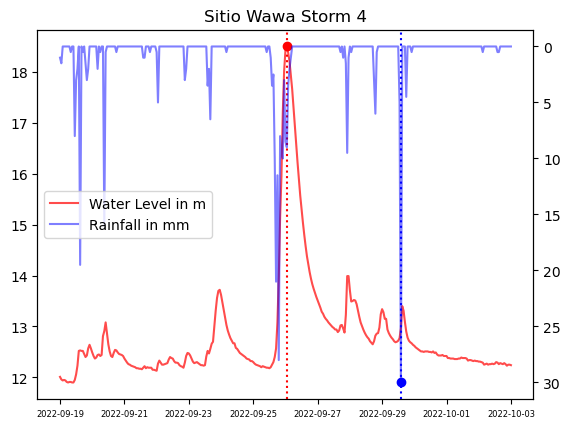

In [35]:
make_rainfall_hydrograph(sitio_wawa_storm_event4, 'Sitio Wawa Storm 4', '1hr', sw_max_1rain_4, sw_max_water_4)

In [36]:
sitio_wawa_storm_event5 = get_storm_event(sitio_wawa_df, '2022-10-30', days=7)
sitio_wawa_storm_event5.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
184103,2022-10-23 00:00:00,12.03,Sitio Wawa,0.0,0.0,0.0,0.0,0.0,00:00:00
184129,2022-10-23 01:00:00,12.02,Sitio Wawa,0.0,0.0,0.0,0.0,0.0,01:00:00
184155,2022-10-23 02:00:00,12.01,Sitio Wawa,0.0,0.0,0.0,0.0,0.0,02:00:00
184181,2022-10-23 03:00:00,11.99,Sitio Wawa,0.0,0.0,0.0,0.0,0.0,03:00:00
184207,2022-10-23 04:00:00,11.98,Sitio Wawa,0.0,0.0,0.0,0.0,0.0,04:00:00


In [37]:
sitio_wawa_storm_event5.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
192735,2022-11-05 20:00:00,12.88,Sitio Wawa,0.0,0.0,0.0,0.0,0.5,20:00:00
192761,2022-11-05 21:00:00,12.87,Sitio Wawa,0.0,0.0,0.0,0.0,0.0,21:00:00
192787,2022-11-05 22:00:00,12.87,Sitio Wawa,0.0,0.0,0.0,0.0,0.0,22:00:00
192813,2022-11-05 23:00:00,12.86,Sitio Wawa,0.0,0.0,0.0,0.0,0.0,23:00:00
192839,2022-11-06 00:00:00,12.86,Sitio Wawa,0.0,0.0,0.0,0.0,0.0,00:00:00


In [38]:
sw_max_water_5, sw_max_1rain_5, sw_max_24rain_5 = get_maxes(sitio_wawa_storm_event5)

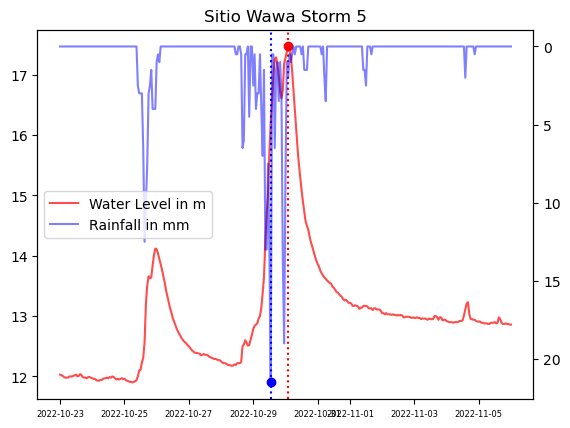

In [39]:
make_rainfall_hydrograph(sitio_wawa_storm_event5, 'Sitio Wawa Storm 5', '1hr', sw_max_1rain_5, sw_max_water_5)

### Removing 0's from whole dataframe before getting correlations

In [40]:
no_zero_1hr = df['1hr'] != 0
no_zero_3hr = df['3hr'] != 0
no_zero_6hr = df['6hr'] != 0
no_zero_12hr = df['12hr'] != 0
no_zero_24hr = df['24hr'] != 0

df_no_zero = df[no_zero_1hr & no_zero_3hr & no_zero_6hr & no_zero_12hr & no_zero_24hr]

for station in stations:
    df_no_zero_subset = df_no_zero[df_no_zero['station'] == station]
    print(f'{station}\n{df_no_zero_subset.corr()}\n\n')
    
# Pintong Bukawe has highest correlation between water level and 24hr rain

Airport (PAGASA)
             water_level       1hr       3hr       6hr      12hr      24hr
water_level     1.000000  0.218995  0.317620  0.492515  0.630448  0.627015
1hr             0.218995  1.000000  0.572801  0.454559  0.390858  0.303680
3hr             0.317620  0.572801  1.000000  0.843643  0.664049  0.517258
6hr             0.492515  0.454559  0.843643  1.000000  0.861258  0.714246
12hr            0.630448  0.390858  0.664049  0.861258  1.000000  0.887349
24hr            0.627015  0.303680  0.517258  0.714246  0.887349  1.000000


Antipolo
             water_level       1hr       3hr       6hr      12hr      24hr
water_level     1.000000  0.074775  0.278155  0.494826  0.631467  0.699822
1hr             0.074775  1.000000  0.640523  0.453954  0.308644  0.233917
3hr             0.278155  0.640523  1.000000  0.818822  0.615484  0.495676
6hr             0.494826  0.453954  0.818822  1.000000  0.838363  0.711096
12hr            0.631467  0.308644  0.615484  0.838363  1.000000  0.8878

Pintong Bukawe


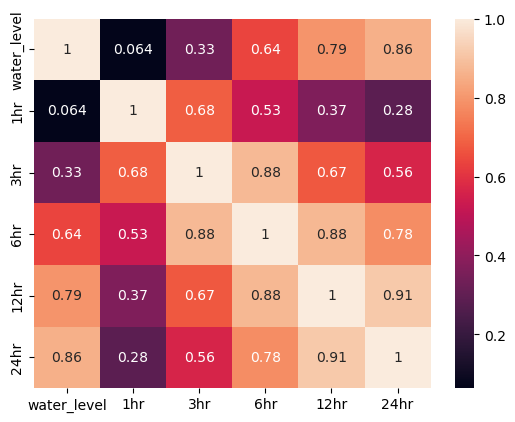

In [41]:
df_no_zero_subset = df_no_zero[df_no_zero['station'] == 'Pintong Bukawe']
print('Pintong Bukawe')
make_corr_heatmap(df_no_zero_subset)

In [42]:
df_no_zero.describe()

,water_level,1hr,3hr,6hr,12hr,24hr
count,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000
mean,12.568643,3.865937,8.611692,12.562042,17.667337,24.386578
std,1.309586,6.489066,11.691089,15.745047,21.809920,29.000215
min,11.010000,0.500000,0.500000,0.500000,0.500000,0.500000
25%,11.780000,0.500000,1.000000,2.000000,2.500000,4.000000
50%,12.290000,1.500000,4.000000,6.000000,8.500000,13.000000
75%,12.810000,4.000000,11.000000,17.500000,25.000000,35.000000
max,18.500000,97.000000,161.500000,163.000000,163.000000,209.000000


In [43]:
pintong_bukawe_df_no_zero = df_no_zero[df_no_zero['station']=='Pintong Bukawe']
pintong_bukawe_df_no_zero

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
30230,2022-02-18 10:00:00,11.05,Pintong Bukawe,3.5,3.5,3.5,3.5,3.5,10:00:00
30256,2022-02-18 11:00:00,11.07,Pintong Bukawe,0.5,4.0,4.0,4.0,4.0,11:00:00
30282,2022-02-18 12:00:00,11.10,Pintong Bukawe,7.5,11.5,11.5,11.5,11.5,12:00:00
30308,2022-02-18 13:00:00,11.13,Pintong Bukawe,1.0,9.0,12.5,12.5,12.5,13:00:00
54228,2022-03-28 21:00:00,11.29,Pintong Bukawe,5.0,5.0,5.0,5.0,5.0,21:00:00
...,...,...,...,...,...,...,...,...,...
214518,2022-12-10 18:00:00,12.68,Pintong Bukawe,5.0,5.5,5.5,5.5,7.0,18:00:00
214544,2022-12-10 19:00:00,12.64,Pintong Bukawe,37.0,42.5,42.5,42.5,44.0,19:00:00
214570,2022-12-10 20:00:00,12.42,Pintong Bukawe,16.5,58.5,59.0,59.0,60.5,20:00:00
214596,2022-12-10 21:00:00,12.51,Pintong Bukawe,0.5,54.0,59.5,59.5,61.0,21:00:00


In [83]:
daily_pb_df = daily_df[daily_df['station'] == 'Pintong Bukawe']
daily_pb_df

,datetime,water_level,station,24hr
18,2022-01-01,11.64,Pintong Bukawe,0.0
642,2022-01-02,11.64,Pintong Bukawe,0.0
1266,2022-01-03,11.64,Pintong Bukawe,0.0
1890,2022-01-04,11.67,Pintong Bukawe,0.0
2514,2022-01-05,11.68,Pintong Bukawe,0.0
...,...,...,...,...
225282,2022-12-28,12.19,Pintong Bukawe,0.0
225906,2022-12-29,12.17,Pintong Bukawe,0.0
226530,2022-12-30,12.11,Pintong Bukawe,0.0
227154,2022-12-31,12.12,Pintong Bukawe,0.0


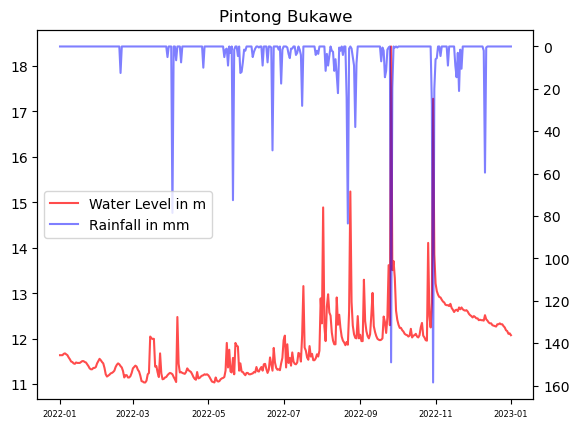

In [45]:
make_rainfall_hydrograph(daily_pb_df, 'Pintong Bukawe', '24hr')

In [46]:
daily_pb_df.sort_values(by='24hr', ascending=False).head()

,datetime,water_level,station,24hr
188466,2022-10-30,17.28,Pintong Bukawe,158.5
167250,2022-09-26,18.43,Pintong Bukawe,149.0
145410,2022-08-22,11.87,Pintong Bukawe,83.5
56802,2022-04-02,11.22,Pintong Bukawe,78.5
87378,2022-05-21,11.58,Pintong Bukawe,72.5


In [47]:
pintong_bukawe_df = df[df['station']=='Pintong Bukawe']
pintong_bukawe_df

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
18,2022-01-01 00:00:00,11.64,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,00:00:00
44,2022-01-01 01:00:00,11.61,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,01:00:00
70,2022-01-01 02:00:00,11.58,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,02:00:00
96,2022-01-01 03:00:00,11.55,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,03:00:00
122,2022-01-01 04:00:00,11.49,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,04:00:00
...,...,...,...,...,...,...,...,...,...
227674,2022-12-31 20:00:00,12.11,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,20:00:00
227700,2022-12-31 21:00:00,12.11,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,21:00:00
227726,2022-12-31 22:00:00,12.09,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,22:00:00
227752,2022-12-31 23:00:00,12.09,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,23:00:00


In [48]:
pb_storm_event1 = get_storm_event(pintong_bukawe_df, '2022-04-02', days=5)
pb_storm_event1.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
53682,2022-03-28 00:00:00,11.16,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,00:00:00
53708,2022-03-28 01:00:00,11.13,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,01:00:00
53734,2022-03-28 02:00:00,11.10,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,02:00:00
53760,2022-03-28 03:00:00,11.07,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,03:00:00
53786,2022-03-28 04:00:00,11.04,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,04:00:00


In [49]:
pb_storm_event1.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
59818,2022-04-06 20:00:00,11.54,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,20:00:00
59844,2022-04-06 21:00:00,11.52,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,21:00:00
59870,2022-04-06 22:00:00,11.50,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,22:00:00
59896,2022-04-06 23:00:00,11.45,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,23:00:00
59922,2022-04-07 00:00:00,11.45,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,00:00:00


In [50]:
pb_max_water_1, pb_max_1rain_1, pb_max_24rain_1 = get_maxes(pb_storm_event1)

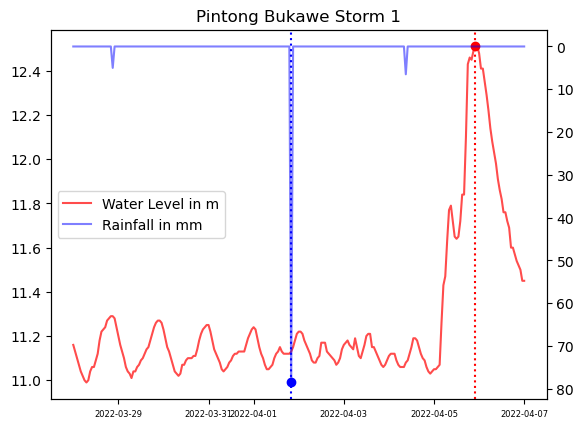

In [51]:
make_rainfall_hydrograph(pb_storm_event1, 'Pintong Bukawe Storm 1', '1hr', pb_max_1rain_1, pb_max_water_1)

In [73]:
pb_storm_event2 = get_storm_event(pintong_bukawe_df, '2022-05-21', days=7)
pb_storm_event2.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
83010,2022-05-14 00:00:00,11.16,Pintong Bukawe,0.0,0.0,0.0,5.0,5.0,00:00:00
83036,2022-05-14 01:00:00,11.16,Pintong Bukawe,0.0,0.0,0.0,5.0,5.0,01:00:00
83062,2022-05-14 02:00:00,11.13,Pintong Bukawe,0.0,0.0,0.0,0.0,5.0,02:00:00
83088,2022-05-14 03:00:00,11.12,Pintong Bukawe,0.0,0.0,0.0,0.0,5.0,03:00:00
83114,2022-05-14 04:00:00,11.09,Pintong Bukawe,0.0,0.0,0.0,0.0,5.0,04:00:00


In [74]:
pb_storm_event2.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
91642,2022-05-27 20:00:00,11.30,Pintong Bukawe,0.0,12.0,12.0,12.0,24.5,20:00:00
91668,2022-05-27 21:00:00,11.28,Pintong Bukawe,0.0,3.5,12.0,12.0,24.5,21:00:00
91694,2022-05-27 22:00:00,11.29,Pintong Bukawe,0.0,0.0,12.0,12.0,12.0,22:00:00
91720,2022-05-27 23:00:00,11.29,Pintong Bukawe,0.0,0.0,12.0,12.0,12.0,23:00:00
91746,2022-05-28 00:00:00,11.28,Pintong Bukawe,0.0,0.0,3.5,12.0,12.0,00:00:00


In [75]:
pb_max_water_2, pb_max_1rain_2, pb_max_24rain_2 = get_maxes(pb_storm_event2)

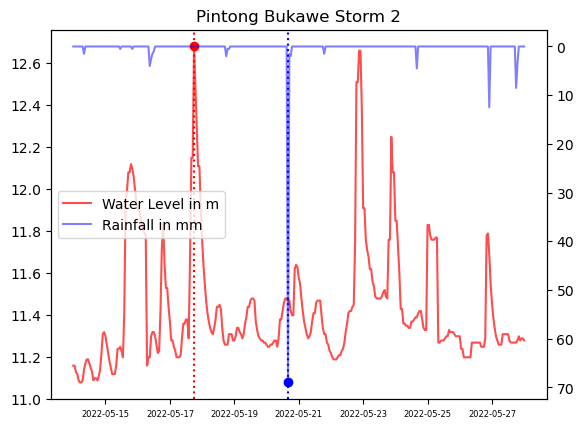

In [76]:
make_rainfall_hydrograph(pb_storm_event2, 'Pintong Bukawe Storm 2', '1hr', pb_max_1rain_2, pb_max_water_2)

In [62]:
pb_storm_event3 = get_storm_event(pintong_bukawe_df, '2022-08-22', days=10)
pb_storm_event3.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
139170,2022-08-12 00:00:00,11.88,Pintong Bukawe,0.0,0.0,1.5,6.0,6.0,00:00:00
139196,2022-08-12 01:00:00,11.86,Pintong Bukawe,0.0,0.0,0.5,6.0,6.0,01:00:00
139222,2022-08-12 02:00:00,11.86,Pintong Bukawe,0.0,0.0,0.0,6.0,6.0,02:00:00
139248,2022-08-12 03:00:00,11.86,Pintong Bukawe,0.0,0.0,0.0,6.0,6.0,03:00:00
139274,2022-08-12 04:00:00,11.86,Pintong Bukawe,0.0,0.0,0.0,5.5,6.0,04:00:00


In [63]:
pb_storm_event3.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
151546,2022-08-31 20:00:00,12.01,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,20:00:00
151572,2022-08-31 21:00:00,11.97,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,21:00:00
151598,2022-08-31 22:00:00,11.97,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,22:00:00
151624,2022-08-31 23:00:00,11.98,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,23:00:00
151650,2022-09-01 00:00:00,12.09,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,00:00:00


In [64]:
pb_max_water_3, pb_max_1rain_3, pb_max_24rain_3 = get_maxes(pb_storm_event3)

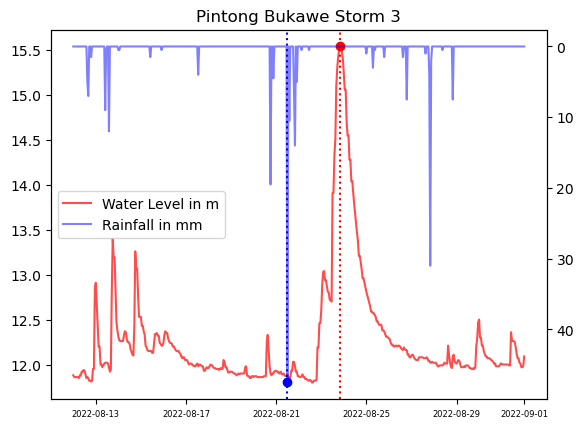

In [65]:
make_rainfall_hydrograph(pb_storm_event3, 'Pintong Bukawe Storm 3', '1hr', pb_max_1rain_3, pb_max_water_3)

In [67]:
pb_storm_event4 = get_storm_event(pintong_bukawe_df, '2022-09-26', days=7)
pb_storm_event4.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
162882,2022-09-19 00:00:00,12.01,Pintong Bukawe,0.0,0.0,0.0,0.0,0.5,00:00:00
162908,2022-09-19 01:00:00,11.96,Pintong Bukawe,0.0,0.0,0.0,0.0,0.5,01:00:00
162934,2022-09-19 02:00:00,11.94,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,02:00:00
162960,2022-09-19 03:00:00,11.95,Pintong Bukawe,1.0,1.0,1.0,1.0,1.0,03:00:00
162986,2022-09-19 04:00:00,11.94,Pintong Bukawe,0.5,1.5,1.5,1.5,1.5,04:00:00


In [68]:
pb_storm_event4.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
171514,2022-10-02 20:00:00,12.26,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,20:00:00
171540,2022-10-02 21:00:00,12.23,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,21:00:00
171566,2022-10-02 22:00:00,12.25,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,22:00:00
171592,2022-10-02 23:00:00,12.25,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,23:00:00
171618,2022-10-03 00:00:00,12.24,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,00:00:00


In [69]:
pb_max_water_4, pb_max_1rain_4, pb_max_24rain_4 = get_maxes(pb_storm_event4)

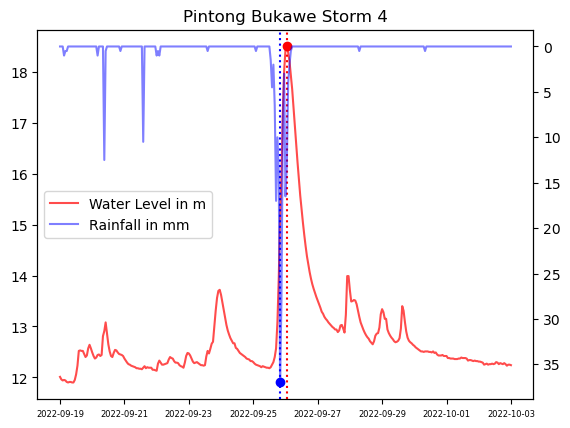

In [72]:
make_rainfall_hydrograph(pb_storm_event4, 'Pintong Bukawe Storm 4', '1hr', pb_max_1rain_4, pb_max_water_4)

In [77]:
pb_storm_event5 = get_storm_event(pintong_bukawe_df, '2022-10-30', days=7)
pb_storm_event5.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
184098,2022-10-23 00:00:00,12.03,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,00:00:00
184124,2022-10-23 01:00:00,12.02,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,01:00:00
184150,2022-10-23 02:00:00,12.01,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,02:00:00
184176,2022-10-23 03:00:00,11.99,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,03:00:00
184202,2022-10-23 04:00:00,11.98,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,04:00:00


In [78]:
pb_storm_event5.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
192730,2022-11-05 20:00:00,12.88,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,20:00:00
192756,2022-11-05 21:00:00,12.87,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,21:00:00
192782,2022-11-05 22:00:00,12.87,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,22:00:00
192808,2022-11-05 23:00:00,12.86,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,23:00:00
192834,2022-11-06 00:00:00,12.86,Pintong Bukawe,0.0,0.0,0.0,0.0,0.0,00:00:00


In [79]:
pb_max_water_5, pb_max_1rain_5, pb_max_24rain_5 = get_maxes(pb_storm_event5)

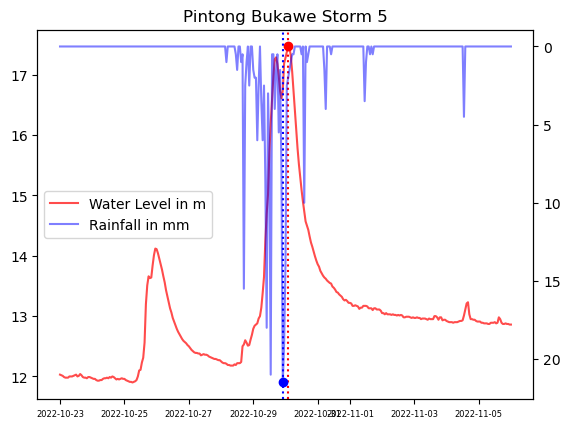

In [80]:
make_rainfall_hydrograph(pb_storm_event5, 'Pintong Bukawe Storm 5', '1hr', pb_max_1rain_5, pb_max_water_5)

## Checking stations used in old research

The main stations were Nangka, Mt. Oro, Mt. Campana, Mt. Aries, Boso Boso.

### Nangka

In [84]:
daily_nangka_df = daily_df[daily_df['station'] == 'Nangka']
daily_nangka_df

,datetime,water_level,station,24hr
14,2022-01-01,11.64,Nangka,0.0
638,2022-01-02,11.64,Nangka,0.0
1262,2022-01-03,11.64,Nangka,0.0
1886,2022-01-04,11.67,Nangka,0.0
2510,2022-01-05,11.68,Nangka,0.0
...,...,...,...,...
225278,2022-12-28,12.19,Nangka,0.0
225902,2022-12-29,12.17,Nangka,0.0
226526,2022-12-30,12.11,Nangka,0.0
227150,2022-12-31,12.12,Nangka,0.0


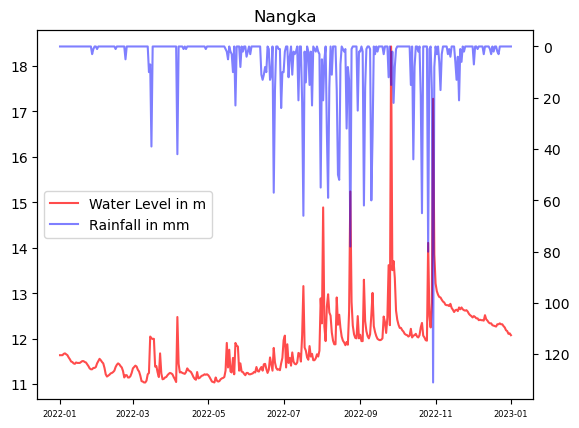

In [85]:
make_rainfall_hydrograph(daily_nangka_df, 'Nangka', '24hr')

In [124]:
daily_nangka_df.sort_values(by='24hr', ascending=False).head(10)

,datetime,water_level,station,24hr
188462,2022-10-30,17.28,Nangka,131.0
185966,2022-10-26,14.11,Nangka,80.0
146654,2022-08-24,15.24,Nangka,78.0
122942,2022-07-17,13.16,Nangka,66.0
182846,2022-10-21,12.35,Nangka,65.0
153518,2022-09-04,13.30,Nangka,62.0
157262,2022-09-10,12.52,Nangka,60.0
135422,2022-08-06,12.98,Nangka,59.0
107966,2022-06-23,11.80,Nangka,57.0
131678,2022-07-31,12.89,Nangka,55.0


In [90]:
nangka_df = df[df['station']=='Nangka']
nangka_df

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
14,2022-01-01 00:00:00,11.64,Nangka,0.0,0.0,0.0,0.0,0.0,00:00:00
40,2022-01-01 01:00:00,11.61,Nangka,0.0,0.0,0.0,0.0,0.0,01:00:00
66,2022-01-01 02:00:00,11.58,Nangka,0.0,0.0,0.0,0.0,0.0,02:00:00
92,2022-01-01 03:00:00,11.55,Nangka,0.0,0.0,0.0,0.0,0.0,03:00:00
118,2022-01-01 04:00:00,11.49,Nangka,0.0,0.0,0.0,0.0,0.0,04:00:00
...,...,...,...,...,...,...,...,...,...
227670,2022-12-31 20:00:00,12.11,Nangka,0.0,0.0,0.0,0.0,0.0,20:00:00
227696,2022-12-31 21:00:00,12.11,Nangka,0.0,0.0,0.0,0.0,0.0,21:00:00
227722,2022-12-31 22:00:00,12.09,Nangka,0.0,0.0,0.0,0.0,0.0,22:00:00
227748,2022-12-31 23:00:00,12.09,Nangka,0.0,0.0,0.0,0.0,0.0,23:00:00


In [91]:
nangka_storm_event1 = get_storm_event(nangka_df, '2022-07-17', days=7)
nangka_storm_event1.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
118574,2022-07-10 00:00:00,11.45,Nangka,0.0,0.0,0.0,0.0,3.0,00:00:00
118600,2022-07-10 01:00:00,11.44,Nangka,0.0,0.0,0.0,0.0,3.0,01:00:00
118626,2022-07-10 02:00:00,11.44,Nangka,2.0,2.0,2.0,2.0,5.0,02:00:00
118652,2022-07-10 03:00:00,11.45,Nangka,0.0,2.0,2.0,2.0,5.0,03:00:00
118678,2022-07-10 04:00:00,11.47,Nangka,0.0,2.0,2.0,2.0,2.0,04:00:00


In [92]:
nangka_storm_event1.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
127206,2022-07-23 20:00:00,11.95,Nangka,0.0,0.0,11.0,23.0,23.0,20:00:00
127232,2022-07-23 21:00:00,11.77,Nangka,0.0,0.0,11.0,23.0,23.0,21:00:00
127258,2022-07-23 22:00:00,11.72,Nangka,0.0,0.0,1.0,23.0,23.0,22:00:00
127284,2022-07-23 23:00:00,11.72,Nangka,0.0,0.0,0.0,23.0,23.0,23:00:00
127310,2022-07-24 00:00:00,11.67,Nangka,0.0,0.0,0.0,23.0,23.0,00:00:00


In [93]:
nangka_max_water_1, nangka_max_1rain_1, nangka_max_24rain_1 = get_maxes(nangka_storm_event1)

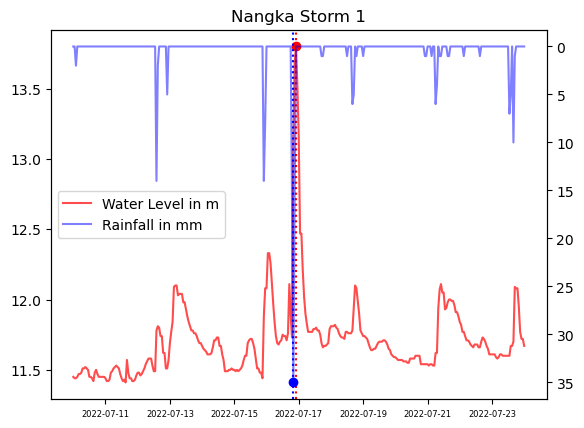

In [94]:
make_rainfall_hydrograph(nangka_storm_event1, 'Nangka Storm 1', '1hr', nangka_max_1rain_1, nangka_max_water_1)

In [125]:
nangka_storm_event2 = get_storm_event(nangka_df, '2022-08-24', days=5)
nangka_storm_event2.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
143534,2022-08-19 00:00:00,11.92,Nangka,0.0,0.0,0.0,2.0,2.0,00:00:00
143560,2022-08-19 01:00:00,11.92,Nangka,0.0,0.0,0.0,2.0,2.0,01:00:00
143586,2022-08-19 02:00:00,11.91,Nangka,0.0,0.0,0.0,2.0,2.0,02:00:00
143612,2022-08-19 03:00:00,11.90,Nangka,0.0,0.0,0.0,2.0,2.0,03:00:00
143638,2022-08-19 04:00:00,11.90,Nangka,0.0,0.0,0.0,0.0,2.0,04:00:00


In [126]:
nangka_storm_event2.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
149670,2022-08-28 20:00:00,12.09,Nangka,0.0,0.0,0.0,0.0,0.0,20:00:00
149696,2022-08-28 21:00:00,12.11,Nangka,0.0,0.0,0.0,0.0,0.0,21:00:00
149722,2022-08-28 22:00:00,12.03,Nangka,0.0,0.0,0.0,0.0,0.0,22:00:00
149748,2022-08-28 23:00:00,12.02,Nangka,0.0,0.0,0.0,0.0,0.0,23:00:00
149774,2022-08-29 00:00:00,12.01,Nangka,0.0,0.0,0.0,0.0,0.0,00:00:00


In [127]:
nangka_max_water_2, nangka_max_1rain_2, nangka_max_24rain_2 = get_maxes(nangka_storm_event2)

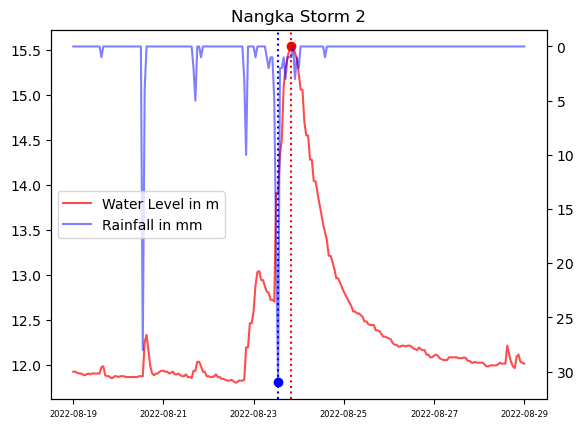

In [128]:
make_rainfall_hydrograph(nangka_storm_event2, 'Nangka Storm 2', '1hr', nangka_max_1rain_2, nangka_max_water_2)

In [129]:
nangka_storm_event3 = get_storm_event(nangka_df, '2022-10-26', days=14)
nangka_storm_event3.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
177230,2022-10-12 00:00:00,12.22,Nangka,0.0,15.0,15.0,15.0,15.0,00:00:00
177256,2022-10-12 01:00:00,12.14,Nangka,0.0,0.0,15.0,15.0,15.0,01:00:00
177282,2022-10-12 02:00:00,12.10,Nangka,0.0,0.0,15.0,15.0,15.0,02:00:00
177308,2022-10-12 03:00:00,12.17,Nangka,0.0,0.0,15.0,15.0,15.0,03:00:00
177334,2022-10-12 04:00:00,12.18,Nangka,0.0,0.0,0.0,15.0,15.0,04:00:00


In [130]:
nangka_storm_event3.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
194598,2022-11-08 20:00:00,12.77,Nangka,0.0,0.0,0.0,0.0,0.0,20:00:00
194624,2022-11-08 21:00:00,12.77,Nangka,0.0,0.0,0.0,0.0,0.0,21:00:00
194650,2022-11-08 22:00:00,12.77,Nangka,0.0,0.0,0.0,0.0,0.0,22:00:00
194676,2022-11-08 23:00:00,12.77,Nangka,0.0,0.0,0.0,0.0,0.0,23:00:00
194702,2022-11-09 00:00:00,12.75,Nangka,0.0,0.0,0.0,0.0,0.0,00:00:00


In [131]:
nangka_max_water_3, nangka_max_1rain_3, nangka_max_24rain_3 = get_maxes(nangka_storm_event3)

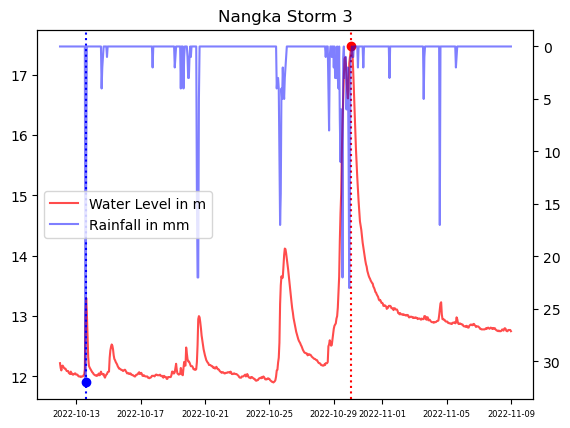

In [132]:
make_rainfall_hydrograph(nangka_storm_event3, 'Nangka Storm 3', '1hr', nangka_max_1rain_3, nangka_max_water_3)

### Mt. Oro

In [134]:
daily_oro_df = daily_df[daily_df['station'] == 'Mt. Oro']
daily_oro_df

,datetime,water_level,station,24hr
13,2022-01-01,11.64,Mt. Oro,0.0
637,2022-01-02,11.64,Mt. Oro,0.0
1261,2022-01-03,11.64,Mt. Oro,0.0
1885,2022-01-04,11.67,Mt. Oro,0.0
2509,2022-01-05,11.68,Mt. Oro,0.0
...,...,...,...,...
225277,2022-12-28,12.19,Mt. Oro,0.0
225901,2022-12-29,12.17,Mt. Oro,0.0
226525,2022-12-30,12.11,Mt. Oro,2.0
227149,2022-12-31,12.12,Mt. Oro,0.0


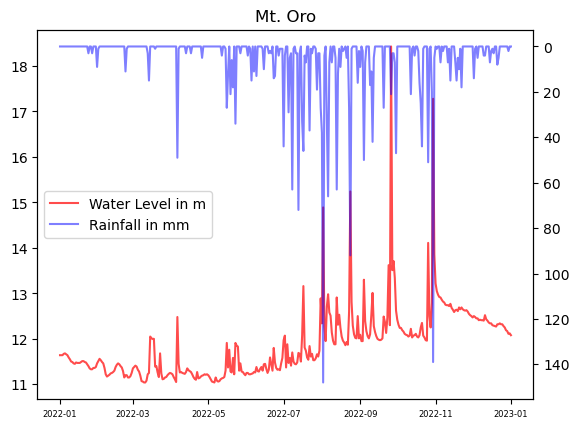

In [135]:
make_rainfall_hydrograph(daily_oro_df, 'Mt. Oro', '24hr')

In [139]:
daily_oro_df.sort_values(by='24hr', ascending=False).head()

,datetime,water_level,station,24hr
132925,2022-08-02,14.89,Mt. Oro,148.0
188461,2022-10-30,17.28,Mt. Oro,139.0
146653,2022-08-24,15.24,Mt. Oro,92.0
120445,2022-07-13,11.69,Mt. Oro,72.0
135421,2022-08-06,12.98,Mt. Oro,66.0


In [140]:
oro_df = df[df['station'] == 'Mt. Oro']
oro_df

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
13,2022-01-01 00:00:00,11.64,Mt. Oro,0.0,0.0,0.0,0.0,0.0,00:00:00
39,2022-01-01 01:00:00,11.61,Mt. Oro,0.0,0.0,0.0,0.0,0.0,01:00:00
65,2022-01-01 02:00:00,11.58,Mt. Oro,0.0,0.0,0.0,0.0,0.0,02:00:00
91,2022-01-01 03:00:00,11.55,Mt. Oro,0.0,0.0,0.0,0.0,0.0,03:00:00
117,2022-01-01 04:00:00,11.49,Mt. Oro,0.0,0.0,0.0,0.0,0.0,04:00:00
...,...,...,...,...,...,...,...,...,...
227669,2022-12-31 20:00:00,12.11,Mt. Oro,0.0,0.0,0.0,0.0,0.0,20:00:00
227695,2022-12-31 21:00:00,12.11,Mt. Oro,0.0,0.0,0.0,0.0,0.0,21:00:00
227721,2022-12-31 22:00:00,12.09,Mt. Oro,0.0,0.0,0.0,0.0,0.0,22:00:00
227747,2022-12-31 23:00:00,12.09,Mt. Oro,0.0,0.0,0.0,0.0,0.0,23:00:00


In [141]:
oro_storm_event1 = get_storm_event(oro_df, '2022-07-13', days=7)
oro_storm_event1.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
116077,2022-07-06 00:00:00,11.58,Mt. Oro,0.0,3.0,4.0,5.0,5.0,00:00:00
116103,2022-07-06 01:00:00,11.54,Mt. Oro,0.0,1.0,4.0,5.0,5.0,01:00:00
116129,2022-07-06 02:00:00,11.50,Mt. Oro,0.0,0.0,3.0,5.0,5.0,02:00:00
116155,2022-07-06 03:00:00,11.49,Mt. Oro,0.0,0.0,3.0,5.0,5.0,03:00:00
116181,2022-07-06 04:00:00,11.44,Mt. Oro,0.0,0.0,1.0,4.0,5.0,04:00:00


In [142]:
oro_storm_event1.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
124709,2022-07-19 20:00:00,11.64,Mt. Oro,0.0,0.0,0.0,0.0,0.0,20:00:00
124735,2022-07-19 21:00:00,11.61,Mt. Oro,0.0,0.0,0.0,0.0,0.0,21:00:00
124761,2022-07-19 22:00:00,11.60,Mt. Oro,0.0,0.0,0.0,0.0,0.0,22:00:00
124787,2022-07-19 23:00:00,11.59,Mt. Oro,0.0,0.0,0.0,0.0,0.0,23:00:00
124813,2022-07-20 00:00:00,11.59,Mt. Oro,0.0,0.0,0.0,0.0,0.0,00:00:00


In [143]:
oro_max_water_1, oro_max_1rain_1, oro_max_24rain_1 = get_maxes(oro_storm_event1)

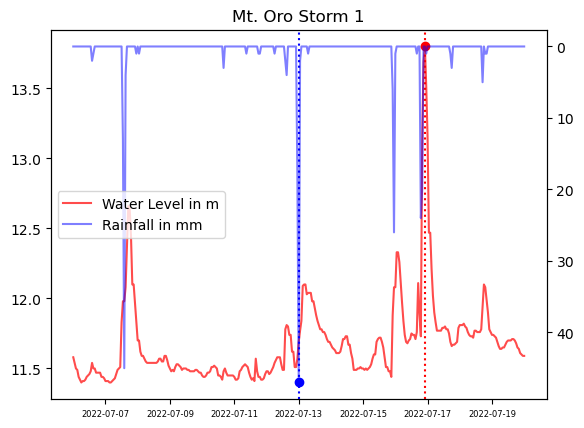

In [144]:
make_rainfall_hydrograph(oro_storm_event1, 'Mt. Oro Storm 1', '1hr', oro_max_1rain_1, oro_max_water_1)

In [145]:
oro_storm_event2 = get_storm_event(oro_df, '2022-08-02', days=7)
oro_storm_event2.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
128557,2022-07-26 00:00:00,11.53,Mt. Oro,0.0,0.0,0.0,0.0,0.0,00:00:00
128583,2022-07-26 01:00:00,11.54,Mt. Oro,0.0,0.0,0.0,0.0,0.0,01:00:00
128609,2022-07-26 02:00:00,11.54,Mt. Oro,0.0,0.0,0.0,0.0,0.0,02:00:00
128635,2022-07-26 03:00:00,11.52,Mt. Oro,0.0,0.0,0.0,0.0,0.0,03:00:00
128661,2022-07-26 04:00:00,11.54,Mt. Oro,0.0,0.0,0.0,0.0,0.0,04:00:00


In [146]:
oro_storm_event2.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
137189,2022-08-08 20:00:00,12.15,Mt. Oro,0.0,0.0,0.0,0.0,5.0,20:00:00
137215,2022-08-08 21:00:00,12.21,Mt. Oro,1.0,1.0,1.0,1.0,6.0,21:00:00
137241,2022-08-08 22:00:00,12.21,Mt. Oro,1.0,2.0,2.0,2.0,7.0,22:00:00
137267,2022-08-08 23:00:00,12.19,Mt. Oro,0.0,2.0,2.0,2.0,7.0,23:00:00
137293,2022-08-09 00:00:00,12.14,Mt. Oro,0.0,1.0,2.0,2.0,7.0,00:00:00


In [147]:
oro_max_water_2, oro_max_1rain_2, oro_max_24rain_2 = get_maxes(oro_storm_event2)

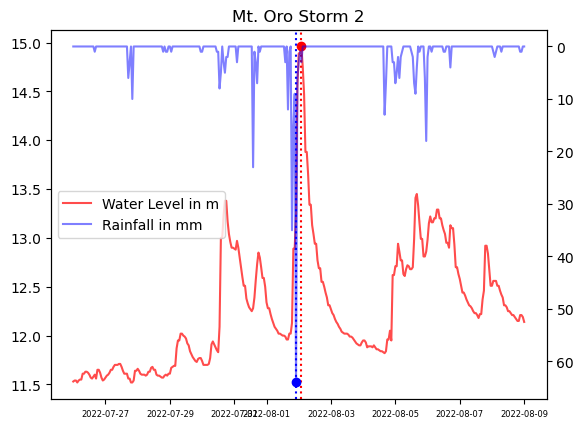

In [148]:
make_rainfall_hydrograph(oro_storm_event2, 'Mt. Oro Storm 2', '1hr', oro_max_1rain_2, oro_max_water_2)

In [149]:
oro_storm_event3 = get_storm_event(oro_df, '2022-08-24', days=7)
oro_storm_event3.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
142285,2022-08-17 00:00:00,12.05,Mt. Oro,0.0,0.0,0.0,0.0,0.0,00:00:00
142311,2022-08-17 01:00:00,12.05,Mt. Oro,0.0,0.0,0.0,0.0,0.0,01:00:00
142337,2022-08-17 02:00:00,12.03,Mt. Oro,0.0,0.0,0.0,0.0,0.0,02:00:00
142363,2022-08-17 03:00:00,12.00,Mt. Oro,0.0,0.0,0.0,0.0,0.0,03:00:00
142389,2022-08-17 04:00:00,12.01,Mt. Oro,0.0,0.0,0.0,0.0,0.0,04:00:00


In [150]:
oro_storm_event3.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
150917,2022-08-30 20:00:00,11.98,Mt. Oro,0.0,0.0,0.0,0.0,17.0,20:00:00
150943,2022-08-30 21:00:00,11.98,Mt. Oro,1.0,1.0,1.0,1.0,5.0,21:00:00
150969,2022-08-30 22:00:00,11.99,Mt. Oro,0.0,1.0,1.0,1.0,2.0,22:00:00
150995,2022-08-30 23:00:00,12.01,Mt. Oro,0.0,1.0,1.0,1.0,2.0,23:00:00
151021,2022-08-31 00:00:00,12.01,Mt. Oro,0.0,0.0,1.0,1.0,2.0,00:00:00


In [151]:
oro_max_water_3, oro_max_1rain_3, oro_max_24rain_3 = get_maxes(oro_storm_event3)

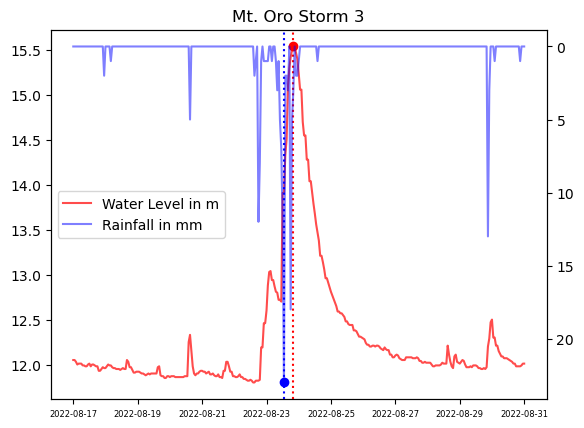

In [152]:
make_rainfall_hydrograph(oro_storm_event3, 'Mt. Oro Storm 3', '1hr', oro_max_1rain_3, oro_max_water_3)

In [153]:
oro_storm_event4 = get_storm_event(oro_df, '2022-10-30', days=7)
oro_storm_event4.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
184093,2022-10-23 00:00:00,12.03,Mt. Oro,0.0,0.0,0.0,0.0,0.0,00:00:00
184119,2022-10-23 01:00:00,12.02,Mt. Oro,0.0,0.0,0.0,0.0,0.0,01:00:00
184145,2022-10-23 02:00:00,12.01,Mt. Oro,0.0,0.0,0.0,0.0,0.0,02:00:00
184171,2022-10-23 03:00:00,11.99,Mt. Oro,0.0,0.0,0.0,0.0,0.0,03:00:00
184197,2022-10-23 04:00:00,11.98,Mt. Oro,0.0,0.0,0.0,0.0,0.0,04:00:00


In [154]:
oro_storm_event4.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
192725,2022-11-05 20:00:00,12.88,Mt. Oro,0.0,0.0,0.0,0.0,0.0,20:00:00
192751,2022-11-05 21:00:00,12.87,Mt. Oro,0.0,0.0,0.0,0.0,0.0,21:00:00
192777,2022-11-05 22:00:00,12.87,Mt. Oro,0.0,0.0,0.0,0.0,0.0,22:00:00
192803,2022-11-05 23:00:00,12.86,Mt. Oro,0.0,0.0,0.0,0.0,0.0,23:00:00
192829,2022-11-06 00:00:00,12.86,Mt. Oro,0.0,0.0,0.0,0.0,0.0,00:00:00


In [155]:
oro_max_water_4, oro_max_1rain_4, oro_max_24rain_4 = get_maxes(oro_storm_event4)

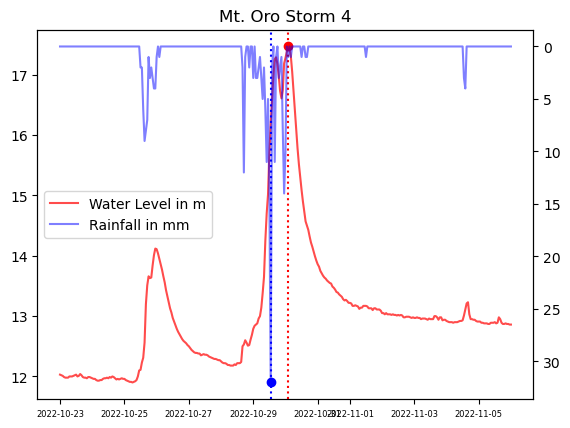

In [156]:
make_rainfall_hydrograph(oro_storm_event4, 'Mt. Oro Storm 4', '1hr', oro_max_1rain_4, oro_max_water_4)

### Mt. Campana

In [157]:
daily_campana_df = daily_df[daily_df['station'] == 'Mt. Campana']
daily_campana_df

,datetime,water_level,station,24hr
12,2022-01-01,11.64,Mt. Campana,0.0
636,2022-01-02,11.64,Mt. Campana,0.0
1260,2022-01-03,11.64,Mt. Campana,0.0
1884,2022-01-04,11.67,Mt. Campana,0.0
2508,2022-01-05,11.68,Mt. Campana,0.0
...,...,...,...,...
225276,2022-12-28,12.19,Mt. Campana,0.0
225900,2022-12-29,12.17,Mt. Campana,0.0
226524,2022-12-30,12.11,Mt. Campana,2.0
227148,2022-12-31,12.12,Mt. Campana,3.0


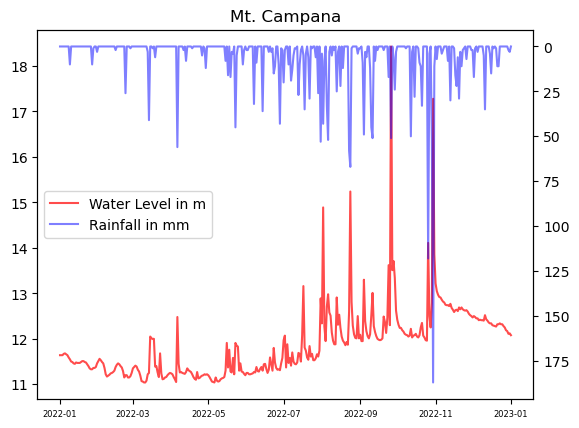

In [158]:
make_rainfall_hydrograph(daily_campana_df, 'Mt. Campana', '24hr')

In [159]:
daily_campana_df.sort_values(by='24hr', ascending=False).head()

,datetime,water_level,station,24hr
188460,2022-10-30,17.28,Mt. Campana,187.0
185964,2022-10-26,14.11,Mt. Campana,118.0
146652,2022-08-24,15.24,Mt. Campana,67.0
146028,2022-08-23,12.60,Mt. Campana,58.0
59292,2022-04-06,12.48,Mt. Campana,56.0


In [160]:
campana_df = df[df['station'] == 'Mt. Campana']
campana_df

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
12,2022-01-01 00:00:00,11.64,Mt. Campana,0.0,0.0,0.0,0.0,0.0,00:00:00
38,2022-01-01 01:00:00,11.61,Mt. Campana,0.0,0.0,0.0,0.0,0.0,01:00:00
64,2022-01-01 02:00:00,11.58,Mt. Campana,0.0,0.0,0.0,0.0,0.0,02:00:00
90,2022-01-01 03:00:00,11.55,Mt. Campana,0.0,0.0,0.0,0.0,0.0,03:00:00
116,2022-01-01 04:00:00,11.49,Mt. Campana,0.0,0.0,0.0,0.0,0.0,04:00:00
...,...,...,...,...,...,...,...,...,...
227668,2022-12-31 20:00:00,12.11,Mt. Campana,0.0,0.0,0.0,0.0,0.0,20:00:00
227694,2022-12-31 21:00:00,12.11,Mt. Campana,0.0,0.0,0.0,0.0,0.0,21:00:00
227720,2022-12-31 22:00:00,12.09,Mt. Campana,0.0,0.0,0.0,0.0,0.0,22:00:00
227746,2022-12-31 23:00:00,12.09,Mt. Campana,0.0,0.0,0.0,0.0,0.0,23:00:00


In [161]:
campana_storm_event1 = get_storm_event(campana_df, '2022-04-06', days=7)
campana_storm_event1.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
54924,2022-03-30 00:00:00,11.23,Mt. Campana,0.0,0.0,0.0,0.0,0.0,00:00:00
54950,2022-03-30 01:00:00,11.19,Mt. Campana,0.0,0.0,0.0,0.0,0.0,01:00:00
54976,2022-03-30 02:00:00,11.15,Mt. Campana,0.0,0.0,0.0,0.0,0.0,02:00:00
55002,2022-03-30 03:00:00,11.13,Mt. Campana,0.0,0.0,0.0,0.0,0.0,03:00:00
55028,2022-03-30 04:00:00,11.10,Mt. Campana,0.0,0.0,0.0,0.0,0.0,04:00:00


In [162]:
campana_storm_event1.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
63556,2022-04-12 20:00:00,11.37,Mt. Campana,0.0,1.0,1.0,4.0,4.0,20:00:00
63582,2022-04-12 21:00:00,11.35,Mt. Campana,0.0,1.0,1.0,4.0,4.0,21:00:00
63608,2022-04-12 22:00:00,11.31,Mt. Campana,0.0,0.0,1.0,4.0,4.0,22:00:00
63634,2022-04-12 23:00:00,11.29,Mt. Campana,1.0,1.0,2.0,2.0,5.0,23:00:00
63660,2022-04-13 00:00:00,11.27,Mt. Campana,3.0,4.0,5.0,5.0,8.0,00:00:00


In [163]:
campana_max_water_1, campana_max_1rain_1, campana_max_24rain_1 = get_maxes(campana_storm_event1)

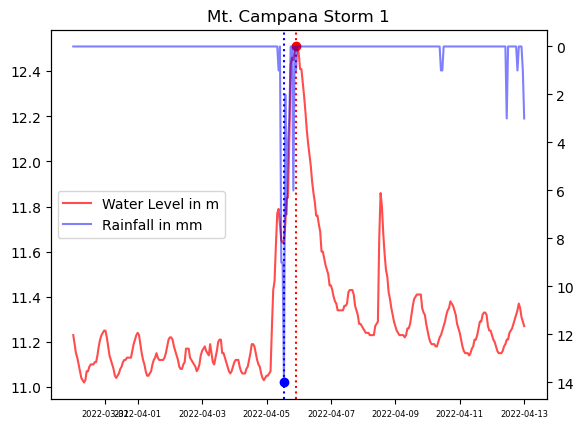

In [164]:
make_rainfall_hydrograph(campana_storm_event1, 'Mt. Campana Storm 1', '1hr', campana_max_1rain_1, campana_max_water_1)

In [165]:
campana_storm_event2 = get_storm_event(campana_df, '2022-08-24', days=7)
campana_storm_event2.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
142284,2022-08-17 00:00:00,12.05,Mt. Campana,0.0,0.0,0.0,0.0,0.0,00:00:00
142310,2022-08-17 01:00:00,12.05,Mt. Campana,0.0,0.0,0.0,0.0,0.0,01:00:00
142336,2022-08-17 02:00:00,12.03,Mt. Campana,0.0,0.0,0.0,0.0,0.0,02:00:00
142362,2022-08-17 03:00:00,12.00,Mt. Campana,0.0,0.0,0.0,0.0,0.0,03:00:00
142388,2022-08-17 04:00:00,12.01,Mt. Campana,0.0,0.0,0.0,0.0,0.0,04:00:00


In [166]:
campana_storm_event2.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
150916,2022-08-30 20:00:00,11.98,Mt. Campana,0.0,0.0,0.0,0.0,4.0,20:00:00
150942,2022-08-30 21:00:00,11.98,Mt. Campana,1.0,1.0,1.0,1.0,5.0,21:00:00
150968,2022-08-30 22:00:00,11.99,Mt. Campana,0.0,1.0,1.0,1.0,2.0,22:00:00
150994,2022-08-30 23:00:00,12.01,Mt. Campana,0.0,1.0,1.0,1.0,1.0,23:00:00
151020,2022-08-31 00:00:00,12.01,Mt. Campana,0.0,0.0,1.0,1.0,1.0,00:00:00


In [167]:
campana_max_water_2, campana_max_1rain_2, campana_max_24rain_2 = get_maxes(campana_storm_event2)

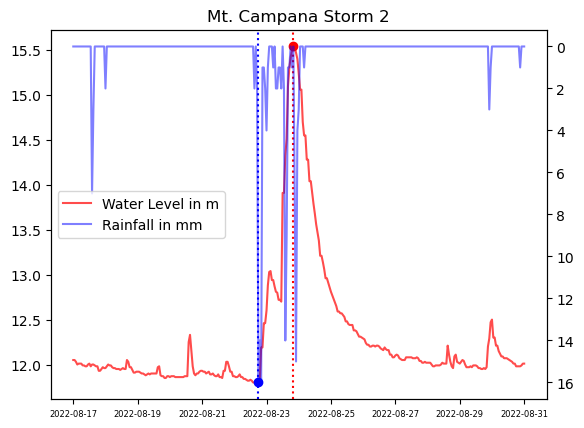

In [168]:
make_rainfall_hydrograph(campana_storm_event2, 'Mt. Campana Storm 2', '1hr', campana_max_1rain_2, campana_max_water_2)

In [169]:
campana_storm_event3 = get_storm_event(campana_df, '2022-10-30', days=7)
campana_storm_event3.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
184092,2022-10-23 00:00:00,12.03,Mt. Campana,0.0,0.0,0.0,0.0,0.0,00:00:00
184118,2022-10-23 01:00:00,12.02,Mt. Campana,0.0,0.0,0.0,0.0,0.0,01:00:00
184144,2022-10-23 02:00:00,12.01,Mt. Campana,0.0,0.0,0.0,0.0,0.0,02:00:00
184170,2022-10-23 03:00:00,11.99,Mt. Campana,0.0,0.0,0.0,0.0,0.0,03:00:00
184196,2022-10-23 04:00:00,11.98,Mt. Campana,0.0,0.0,0.0,0.0,0.0,04:00:00


In [170]:
campana_storm_event3.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
192724,2022-11-05 20:00:00,12.88,Mt. Campana,0.0,0.0,4.0,4.0,4.0,20:00:00
192750,2022-11-05 21:00:00,12.87,Mt. Campana,0.0,0.0,3.0,4.0,4.0,21:00:00
192776,2022-11-05 22:00:00,12.87,Mt. Campana,0.0,0.0,0.0,4.0,4.0,22:00:00
192802,2022-11-05 23:00:00,12.86,Mt. Campana,0.0,0.0,0.0,4.0,4.0,23:00:00
192828,2022-11-06 00:00:00,12.86,Mt. Campana,0.0,0.0,0.0,4.0,4.0,00:00:00


In [171]:
campana_max_water_3, campana_max_1rain_3, campana_max_24rain_3 = get_maxes(campana_storm_event3)

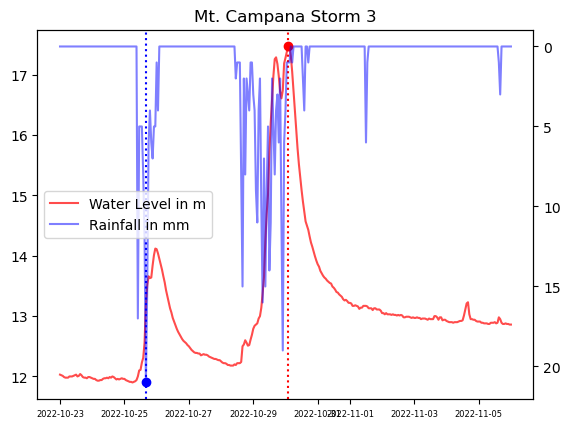

In [172]:
make_rainfall_hydrograph(campana_storm_event3, 'Mt. Campana Storm 3', '1hr', campana_max_1rain_3, campana_max_water_3)

### Mt. Aries

In [173]:
daily_aries_df = daily_df[daily_df['station'] == 'Mt. Aries']
daily_aries_df

,datetime,water_level,station,24hr
11,2022-01-01,11.64,Mt. Aries,0.0
635,2022-01-02,11.64,Mt. Aries,0.0
1259,2022-01-03,11.64,Mt. Aries,0.0
1883,2022-01-04,11.67,Mt. Aries,0.0
2507,2022-01-05,11.68,Mt. Aries,0.0
...,...,...,...,...
225275,2022-12-28,12.19,Mt. Aries,0.0
225899,2022-12-29,12.17,Mt. Aries,0.0
226523,2022-12-30,12.11,Mt. Aries,2.0
227147,2022-12-31,12.12,Mt. Aries,2.0


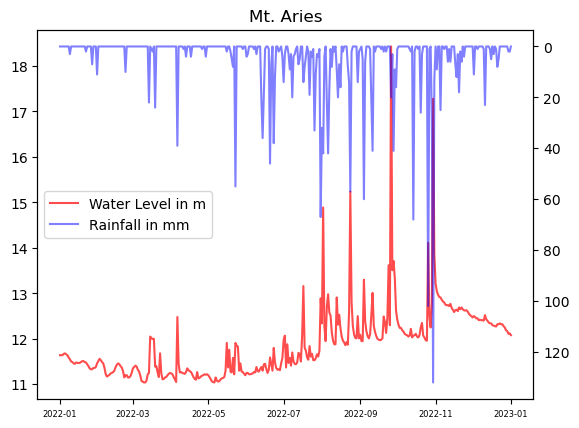

In [174]:
make_rainfall_hydrograph(daily_aries_df, 'Mt. Aries', '24hr')

In [175]:
daily_aries_df.sort_values(by='24hr', ascending=False).head()

,datetime,water_level,station,24hr
188459,2022-10-30,17.28,Mt. Aries,132.0
185963,2022-10-26,14.11,Mt. Aries,102.0
178475,2022-10-14,12.07,Mt. Aries,68.0
131675,2022-07-31,12.89,Mt. Aries,67.0
153515,2022-09-04,13.30,Mt. Aries,60.0


In [176]:
aries_df = df[df['station'] == 'Mt. Aries']
aries_df

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
11,2022-01-01 00:00:00,11.64,Mt. Aries,0.0,0.0,0.0,0.0,0.0,00:00:00
37,2022-01-01 01:00:00,11.61,Mt. Aries,0.0,0.0,0.0,0.0,0.0,01:00:00
63,2022-01-01 02:00:00,11.58,Mt. Aries,0.0,0.0,0.0,0.0,0.0,02:00:00
89,2022-01-01 03:00:00,11.55,Mt. Aries,0.0,0.0,0.0,0.0,0.0,03:00:00
115,2022-01-01 04:00:00,11.49,Mt. Aries,0.0,0.0,0.0,0.0,0.0,04:00:00
...,...,...,...,...,...,...,...,...,...
227667,2022-12-31 20:00:00,12.11,Mt. Aries,0.0,0.0,0.0,0.0,0.0,20:00:00
227693,2022-12-31 21:00:00,12.11,Mt. Aries,0.0,0.0,0.0,0.0,0.0,21:00:00
227719,2022-12-31 22:00:00,12.09,Mt. Aries,0.0,0.0,0.0,0.0,0.0,22:00:00
227745,2022-12-31 23:00:00,12.09,Mt. Aries,0.0,0.0,0.0,0.0,0.0,23:00:00


In [178]:
aries_storm_event1 = get_storm_event(aries_df, '2022-07-31', days=7)
aries_storm_event1.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
127307,2022-07-24 00:00:00,11.67,Mt. Aries,0.0,0.0,0.0,4.0,4.0,00:00:00
127333,2022-07-24 01:00:00,11.65,Mt. Aries,0.0,0.0,0.0,4.0,4.0,01:00:00
127359,2022-07-24 02:00:00,11.65,Mt. Aries,0.0,0.0,0.0,4.0,4.0,02:00:00
127385,2022-07-24 03:00:00,11.63,Mt. Aries,0.0,0.0,0.0,0.0,4.0,03:00:00
127411,2022-07-24 04:00:00,11.61,Mt. Aries,0.0,0.0,0.0,0.0,4.0,04:00:00


In [179]:
aries_storm_event1.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
135939,2022-08-06 20:00:00,12.93,Mt. Aries,0.0,0.0,14.0,17.0,27.0,20:00:00
135965,2022-08-06 21:00:00,12.70,Mt. Aries,0.0,0.0,14.0,16.0,26.0,21:00:00
135991,2022-08-06 22:00:00,12.70,Mt. Aries,0.0,0.0,1.0,16.0,23.0,22:00:00
136017,2022-08-06 23:00:00,12.63,Mt. Aries,0.0,0.0,0.0,16.0,18.0,23:00:00
136043,2022-08-07 00:00:00,12.58,Mt. Aries,0.0,0.0,0.0,15.0,17.0,00:00:00


In [180]:
aries_max_water_1, aries_max_1rain_1, aries_max_24rain_1 = get_maxes(aries_storm_event1)

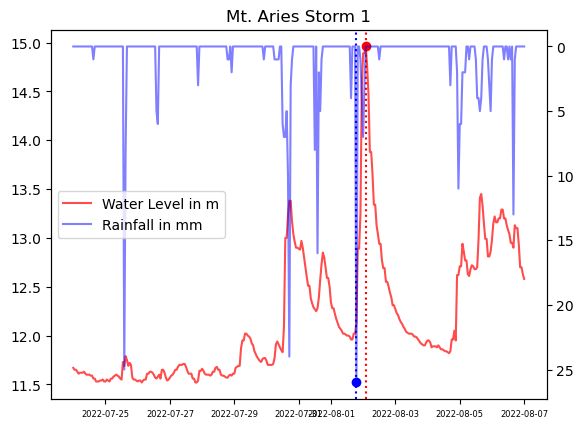

In [181]:
make_rainfall_hydrograph(aries_storm_event1, 'Mt. Aries Storm 1', '1hr', aries_max_1rain_1, aries_max_water_1)

In [222]:
aries_storm_event2 = get_storm_event(aries_df, '2022-09-04', days=10)
aries_storm_event2.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
147275,2022-08-25 00:00:00,12.81,Mt. Aries,0.0,0.0,0.0,0.0,2.0,00:00:00
147301,2022-08-25 01:00:00,12.77,Mt. Aries,0.0,0.0,0.0,0.0,1.0,01:00:00
147327,2022-08-25 02:00:00,12.73,Mt. Aries,0.0,0.0,0.0,0.0,1.0,02:00:00
147353,2022-08-25 03:00:00,12.69,Mt. Aries,0.0,0.0,0.0,0.0,0.0,03:00:00
147379,2022-08-25 04:00:00,12.65,Mt. Aries,0.0,0.0,0.0,0.0,0.0,04:00:00


In [223]:
aries_storm_event2.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
159651,2022-09-13 20:00:00,12.05,Mt. Aries,0.0,0.0,0.0,0.0,0.0,20:00:00
159677,2022-09-13 21:00:00,12.04,Mt. Aries,0.0,0.0,0.0,0.0,0.0,21:00:00
159703,2022-09-13 22:00:00,12.06,Mt. Aries,0.0,0.0,0.0,0.0,0.0,22:00:00
159729,2022-09-13 23:00:00,12.07,Mt. Aries,0.0,0.0,0.0,0.0,0.0,23:00:00
159755,2022-09-14 00:00:00,12.06,Mt. Aries,0.0,0.0,0.0,0.0,0.0,00:00:00


In [224]:
aries_max_water_2, aries_max_1rain_2, aries_max_24rain_2 = get_maxes(aries_storm_event2)

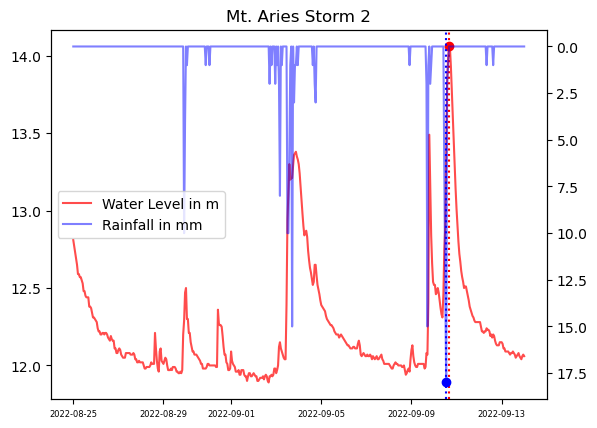

In [225]:
make_rainfall_hydrograph(aries_storm_event2, 'Mt. Aries Storm 2', '1hr', aries_max_1rain_2, aries_max_water_2)

In [187]:
aries_storm_event3 = get_storm_event(aries_df, '2022-10-14', days = 7)
aries_storm_event3.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
174107,2022-10-07 00:00:00,12.11,Mt. Aries,0.0,0.0,0.0,0.0,0.0,00:00:00
174133,2022-10-07 01:00:00,12.11,Mt. Aries,0.0,0.0,0.0,0.0,0.0,01:00:00
174159,2022-10-07 02:00:00,12.10,Mt. Aries,0.0,0.0,0.0,0.0,0.0,02:00:00
174185,2022-10-07 03:00:00,12.11,Mt. Aries,0.0,0.0,0.0,0.0,0.0,03:00:00
174211,2022-10-07 04:00:00,12.11,Mt. Aries,0.0,0.0,0.0,0.0,0.0,04:00:00


In [188]:
aries_storm_event3.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
182739,2022-10-20 20:00:00,12.60,Mt. Aries,0.0,0.0,1.0,1.0,9.0,20:00:00
182765,2022-10-20 21:00:00,12.53,Mt. Aries,0.0,0.0,0.0,1.0,9.0,21:00:00
182791,2022-10-20 22:00:00,12.45,Mt. Aries,0.0,0.0,0.0,1.0,9.0,22:00:00
182817,2022-10-20 23:00:00,12.40,Mt. Aries,0.0,0.0,0.0,1.0,6.0,23:00:00
182843,2022-10-21 00:00:00,12.35,Mt. Aries,0.0,0.0,0.0,1.0,3.0,00:00:00


In [189]:
aries_max_water_3, aries_max_1rain_3, aries_max_24rain_3 = get_maxes(aries_storm_event3)

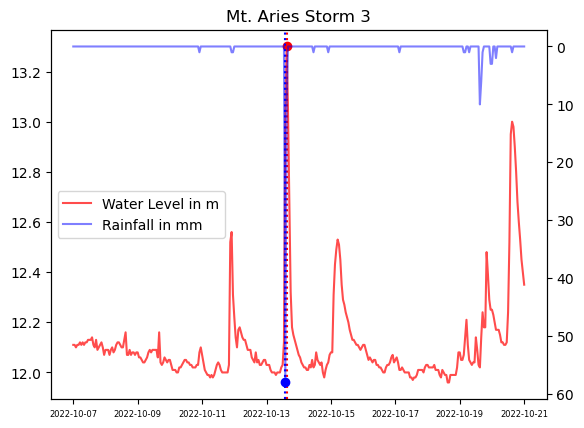

In [226]:
make_rainfall_hydrograph(aries_storm_event3, 'Mt. Aries Storm 3', '1hr', aries_max_1rain_3, aries_max_water_3)

In [192]:
aries_storm_event4 = get_storm_event(aries_df, '2022-10-30', days=7)
aries_storm_event4.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
184091,2022-10-23 00:00:00,12.03,Mt. Aries,0.0,0.0,0.0,0.0,0.0,00:00:00
184117,2022-10-23 01:00:00,12.02,Mt. Aries,0.0,0.0,0.0,0.0,0.0,01:00:00
184143,2022-10-23 02:00:00,12.01,Mt. Aries,0.0,0.0,0.0,0.0,0.0,02:00:00
184169,2022-10-23 03:00:00,11.99,Mt. Aries,0.0,0.0,0.0,0.0,0.0,03:00:00
184195,2022-10-23 04:00:00,11.98,Mt. Aries,0.0,0.0,0.0,0.0,0.0,04:00:00


In [193]:
aries_storm_event4.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
192723,2022-11-05 20:00:00,12.88,Mt. Aries,0.0,0.0,0.0,0.0,0.0,20:00:00
192749,2022-11-05 21:00:00,12.87,Mt. Aries,0.0,0.0,0.0,0.0,0.0,21:00:00
192775,2022-11-05 22:00:00,12.87,Mt. Aries,0.0,0.0,0.0,0.0,0.0,22:00:00
192801,2022-11-05 23:00:00,12.86,Mt. Aries,0.0,0.0,0.0,0.0,0.0,23:00:00
192827,2022-11-06 00:00:00,12.86,Mt. Aries,0.0,0.0,0.0,0.0,0.0,00:00:00


In [194]:
aries_max_water_4, aries_max_1rain_4, aries_max_24rain_4 = get_maxes(aries_storm_event4)

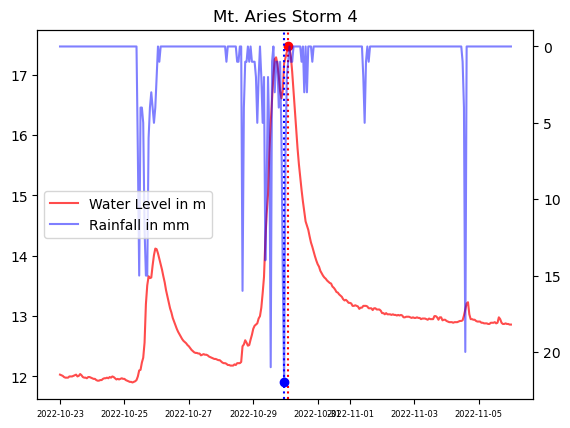

In [195]:
make_rainfall_hydrograph(aries_storm_event4, 'Mt. Aries Storm 4', '1hr', aries_max_1rain_4, aries_max_water_4)

### Boso Boso

In [196]:
daily_boso_df = daily_df[daily_df['station'] == 'Boso Boso']
daily_boso_df

,datetime,water_level,station,24hr
3,2022-01-01,11.64,Boso Boso,0.0
627,2022-01-02,11.64,Boso Boso,0.0
1251,2022-01-03,11.64,Boso Boso,0.0
1875,2022-01-04,11.67,Boso Boso,0.0
2499,2022-01-05,11.68,Boso Boso,0.0
...,...,...,...,...
225267,2022-12-28,12.19,Boso Boso,0.0
225891,2022-12-29,12.17,Boso Boso,0.0
226515,2022-12-30,12.11,Boso Boso,1.0
227139,2022-12-31,12.12,Boso Boso,6.0


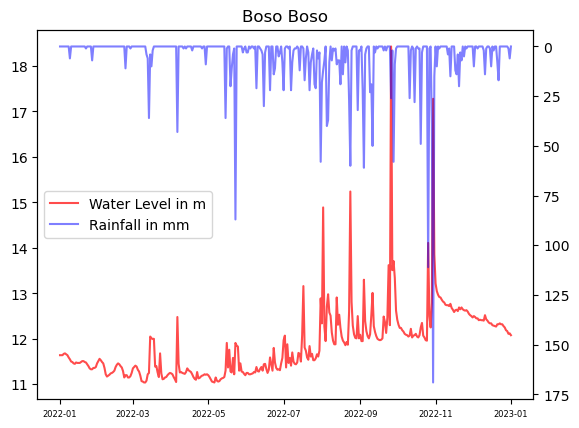

In [197]:
make_rainfall_hydrograph(daily_boso_df, 'Boso Boso', '24hr')

In [198]:
daily_boso_df.sort_values(by='24hr', ascending=False).head()

,datetime,water_level,station,24hr
188451,2022-10-30,17.28,Boso Boso,169.0
185955,2022-10-26,14.11,Boso Boso,111.0
88611,2022-05-23,11.91,Boso Boso,87.0
153507,2022-09-04,13.30,Boso Boso,61.0
146643,2022-08-24,15.24,Boso Boso,60.0


In [199]:
boso_df = df[df['station'] == 'Boso Boso']
boso_df

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
3,2022-01-01 00:00:00,11.64,Boso Boso,0.0,0.0,0.0,0.0,0.0,00:00:00
29,2022-01-01 01:00:00,11.61,Boso Boso,0.0,0.0,0.0,0.0,0.0,01:00:00
55,2022-01-01 02:00:00,11.58,Boso Boso,0.0,0.0,0.0,0.0,0.0,02:00:00
81,2022-01-01 03:00:00,11.55,Boso Boso,0.0,0.0,0.0,0.0,0.0,03:00:00
107,2022-01-01 04:00:00,11.49,Boso Boso,0.0,0.0,0.0,0.0,0.0,04:00:00
...,...,...,...,...,...,...,...,...,...
227659,2022-12-31 20:00:00,12.11,Boso Boso,0.0,0.0,0.0,0.0,0.0,20:00:00
227685,2022-12-31 21:00:00,12.11,Boso Boso,0.0,0.0,0.0,0.0,0.0,21:00:00
227711,2022-12-31 22:00:00,12.09,Boso Boso,0.0,0.0,0.0,0.0,0.0,22:00:00
227737,2022-12-31 23:00:00,12.09,Boso Boso,0.0,0.0,0.0,0.0,0.0,23:00:00


In [205]:
boso_storm_event1 = get_storm_event(boso_df, '2022-05-23', days=10)
boso_storm_event1.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
82371,2022-05-13 00:00:00,11.14,Boso Boso,0.0,0.0,0.0,0.0,0.0,00:00:00
82397,2022-05-13 01:00:00,11.08,Boso Boso,0.0,0.0,0.0,0.0,0.0,01:00:00
82423,2022-05-13 02:00:00,11.08,Boso Boso,0.0,0.0,0.0,0.0,0.0,02:00:00
82449,2022-05-13 03:00:00,11.06,Boso Boso,0.0,0.0,0.0,0.0,0.0,03:00:00
82475,2022-05-13 04:00:00,11.03,Boso Boso,0.0,0.0,0.0,0.0,0.0,04:00:00


In [206]:
boso_storm_event1.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
94747,2022-06-01 20:00:00,11.27,Boso Boso,0.0,0.0,1.0,1.0,3.0,20:00:00
94773,2022-06-01 21:00:00,11.26,Boso Boso,0.0,0.0,0.0,1.0,3.0,21:00:00
94799,2022-06-01 22:00:00,11.26,Boso Boso,0.0,0.0,0.0,1.0,3.0,22:00:00
94825,2022-06-01 23:00:00,11.25,Boso Boso,0.0,0.0,0.0,1.0,3.0,23:00:00
94851,2022-06-02 00:00:00,11.25,Boso Boso,0.0,0.0,0.0,1.0,3.0,00:00:00


In [207]:
boso_max_water_1, boso_max_1rain_1, boso_max_24rain_1 = get_maxes(boso_storm_event1)

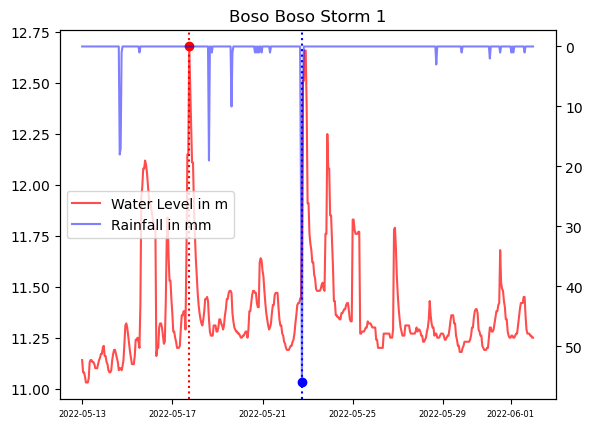

In [208]:
make_rainfall_hydrograph(boso_storm_event1, 'Boso Boso Storm 1', '1hr', boso_max_1rain_1, boso_max_water_1)

In [210]:
boso_storm_event2 = get_storm_event(boso_df, '2022-08-24', days=7)
boso_storm_event2.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
142275,2022-08-17 00:00:00,12.05,Boso Boso,0.0,0.0,0.0,0.0,0.0,00:00:00
142301,2022-08-17 01:00:00,12.05,Boso Boso,0.0,0.0,0.0,0.0,0.0,01:00:00
142327,2022-08-17 02:00:00,12.03,Boso Boso,0.0,0.0,0.0,0.0,0.0,02:00:00
142353,2022-08-17 03:00:00,12.00,Boso Boso,0.0,0.0,0.0,0.0,0.0,03:00:00
142379,2022-08-17 04:00:00,12.01,Boso Boso,0.0,0.0,0.0,0.0,0.0,04:00:00


In [211]:
boso_storm_event2.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
150907,2022-08-30 20:00:00,11.98,Boso Boso,2.0,2.0,2.0,2.0,33.0,20:00:00
150933,2022-08-30 21:00:00,11.98,Boso Boso,2.0,2.0,2.0,2.0,33.0,21:00:00
150959,2022-08-30 22:00:00,11.99,Boso Boso,0.0,2.0,2.0,2.0,16.0,22:00:00
150985,2022-08-30 23:00:00,12.01,Boso Boso,0.0,2.0,2.0,2.0,3.0,23:00:00
151011,2022-08-31 00:00:00,12.01,Boso Boso,0.0,0.0,2.0,2.0,2.0,00:00:00


In [212]:
boso_max_water_2, boso_max_1rain_2, boso_max_24rain_2 = get_maxes(boso_storm_event2)

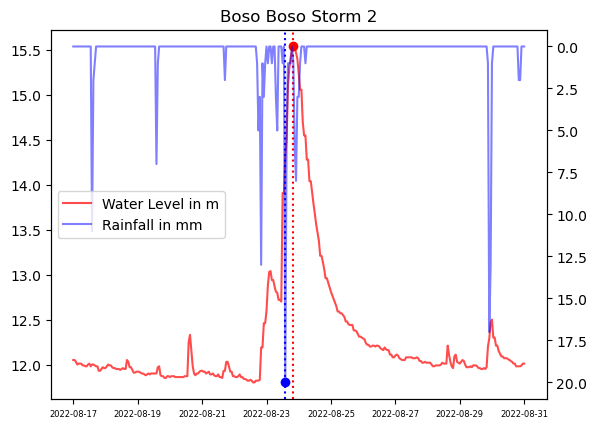

In [213]:
make_rainfall_hydrograph(boso_storm_event2, 'Boso Boso Storm 2', '1hr', boso_max_1rain_2, boso_max_water_2)

In [227]:
boso_storm_event3 = get_storm_event(boso_df, '2022-09-04', days=10)
boso_storm_event3.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
147267,2022-08-25 00:00:00,12.81,Boso Boso,0.0,0.0,0.0,0.0,2.0,00:00:00
147293,2022-08-25 01:00:00,12.77,Boso Boso,0.0,0.0,0.0,0.0,1.0,01:00:00
147319,2022-08-25 02:00:00,12.73,Boso Boso,0.0,0.0,0.0,0.0,1.0,02:00:00
147345,2022-08-25 03:00:00,12.69,Boso Boso,0.0,0.0,0.0,0.0,1.0,03:00:00
147371,2022-08-25 04:00:00,12.65,Boso Boso,0.0,0.0,0.0,0.0,1.0,04:00:00


In [228]:
boso_storm_event3.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
159643,2022-09-13 20:00:00,12.05,Boso Boso,0.0,0.0,0.0,0.0,0.0,20:00:00
159669,2022-09-13 21:00:00,12.04,Boso Boso,0.0,0.0,0.0,0.0,0.0,21:00:00
159695,2022-09-13 22:00:00,12.06,Boso Boso,0.0,0.0,0.0,0.0,0.0,22:00:00
159721,2022-09-13 23:00:00,12.07,Boso Boso,0.0,0.0,0.0,0.0,0.0,23:00:00
159747,2022-09-14 00:00:00,12.06,Boso Boso,0.0,0.0,0.0,0.0,0.0,00:00:00


In [229]:
boso_max_water_3, boso_max_1rain_3, boso_max_24rain_3 = get_maxes(boso_storm_event3)

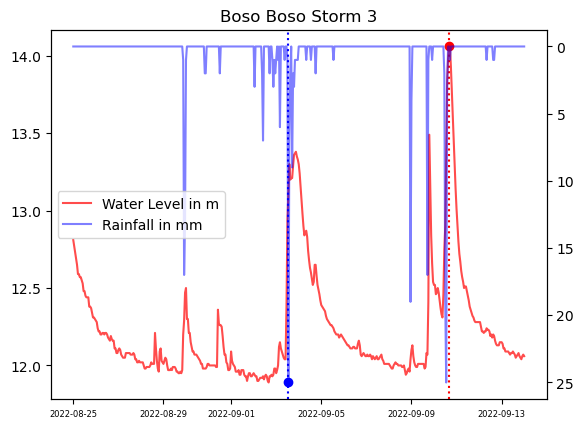

In [230]:
make_rainfall_hydrograph(boso_storm_event3, 'Boso Boso Storm 3', '1hr', boso_max_1rain_3, boso_max_water_3)

In [218]:
boso_storm_event4 = get_storm_event(boso_df, '2022-10-30', days=7)
boso_storm_event4.head()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
184083,2022-10-23 00:00:00,12.03,Boso Boso,0.0,0.0,0.0,0.0,0.0,00:00:00
184109,2022-10-23 01:00:00,12.02,Boso Boso,0.0,0.0,0.0,0.0,0.0,01:00:00
184135,2022-10-23 02:00:00,12.01,Boso Boso,0.0,0.0,0.0,0.0,0.0,02:00:00
184161,2022-10-23 03:00:00,11.99,Boso Boso,0.0,0.0,0.0,0.0,0.0,03:00:00
184187,2022-10-23 04:00:00,11.98,Boso Boso,0.0,0.0,0.0,0.0,0.0,04:00:00


In [219]:
boso_storm_event4.tail()

,datetime,water_level,station,1hr,3hr,6hr,12hr,24hr,time
192715,2022-11-05 20:00:00,12.88,Boso Boso,0.0,0.0,0.0,0.0,0.0,20:00:00
192741,2022-11-05 21:00:00,12.87,Boso Boso,0.0,0.0,0.0,0.0,0.0,21:00:00
192767,2022-11-05 22:00:00,12.87,Boso Boso,0.0,0.0,0.0,0.0,0.0,22:00:00
192793,2022-11-05 23:00:00,12.86,Boso Boso,0.0,0.0,0.0,0.0,0.0,23:00:00
192819,2022-11-06 00:00:00,12.86,Boso Boso,0.0,0.0,0.0,0.0,0.0,00:00:00


In [220]:
boso_max_water_4, boso_max_1rain_4, boso_max_24rain_4 = get_maxes(boso_storm_event4)

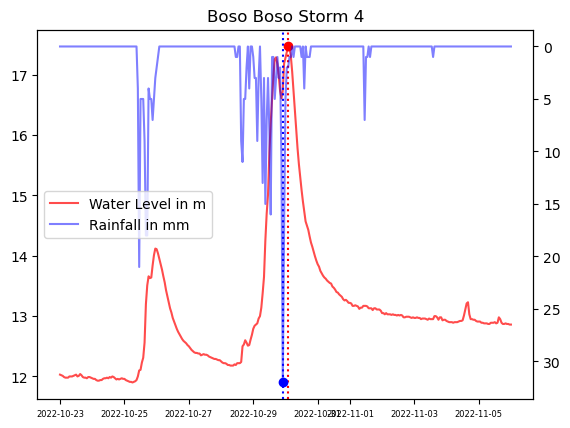

In [221]:
make_rainfall_hydrograph(boso_storm_event4, 'Boso Boso Storm 4', '1hr', boso_max_1rain_4, boso_max_water_4)

## Multiple Linear Regression

In [20]:
X = pintong_bukawe_df_no_zero.iloc[:,3:8]
X

,1hr,3hr,6hr,12hr,24hr
30230,3.5,3.5,3.5,3.5,3.5
30256,0.5,4.0,4.0,4.0,4.0
30282,7.5,11.5,11.5,11.5,11.5
30308,1.0,9.0,12.5,12.5,12.5
54228,5.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...
214518,5.0,5.5,5.5,5.5,7.0
214544,37.0,42.5,42.5,42.5,44.0
214570,16.5,58.5,59.0,59.0,60.5
214596,0.5,54.0,59.5,59.5,61.0


In [23]:
y = pintong_bukawe_df_no_zero.iloc[:, 1]
y

30230     11.05
30256     11.07
30282     11.10
30308     11.13
54228     11.29
          ...  
214518    12.68
214544    12.64
214570    12.42
214596    12.51
214804    12.43
Name: water_level, Length: 261, dtype: float64

In [24]:
model = LinearRegression()
model.fit(X,y)

LinearRegression()

In [25]:
model.score(X,y) #R squared

0.8093116399652062

In [27]:
model.coef_

array([-0.01764951, -0.055263  ,  0.03923418,  0.00429856,  0.02851616])

In [28]:
model.intercept_

11.846213727921597

### With Interaction Term

In [34]:
interaction_term = PolynomialFeatures(interaction_only=True)
X = interaction_term.fit_transform(X)

In [35]:
model.fit(X,y)

LinearRegression()

In [36]:
model.score(X,y) #R squared

0.8278916104721161

In [45]:
coef = model.coef_
coef

array([ 0.00000000e+00, -2.54619743e-02, -6.93289926e-02,  5.40632720e-02,
        7.04128123e-03,  2.20156111e-02, -1.60397126e-03,  3.77753756e-03,
       -3.02721164e-03,  9.87099055e-04, -7.05974032e-04,  3.71021719e-04,
        4.41814759e-04, -9.56606965e-05, -1.45265072e-04,  4.40243849e-05])

In [38]:
model.intercept_

11.893355876054414

In [47]:
predictors = interaction_term.get_feature_names_out()
predictors

array(['1', '1hr', '3hr', '6hr', '12hr', '24hr', '1hr 3hr', '1hr 6hr',
       '1hr 12hr', '1hr 24hr', '3hr 6hr', '3hr 12hr', '3hr 24hr',
       '6hr 12hr', '6hr 24hr', '12hr 24hr'], dtype=object)

In [48]:
for i in range(len(model.coef_)):
    print(f'{predictors[i]}: {coef[i]:.4f}')

1: 0.0000
1hr: -0.0255
3hr: -0.0693
6hr: 0.0541
12hr: 0.0070
24hr: 0.0220
1hr 3hr: -0.0016
1hr 6hr: 0.0038
1hr 12hr: -0.0030
1hr 24hr: 0.0010
3hr 6hr: -0.0007
3hr 12hr: 0.0004
3hr 24hr: 0.0004
6hr 12hr: -0.0001
6hr 24hr: -0.0001
12hr 24hr: 0.0000
